# DQC & ETL

## Библиотеки

In [1]:
# работа с файлами (ETL)
import sys
import os
from pathlib import Path

# работа с данными (DQC & ETL)
import numpy as np
# np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pyxlsb
import scipy

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Чтение данных

In [2]:
%%time
# get directory path
dirpath = os.getcwd()
raw_data_path = Path(dirpath) / 'raw_data'

# load data to dict
data = {}
for file_path in raw_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_excel(file_path)
        print(file_path.stem, data[file_path.stem].shape)

Test (38405, 26)
Training (89734, 26)
CPU times: total: 19.7 s
Wall time: 20.4 s


In [3]:
data['Training'].head(1)

ID         A         B    C      D         E         F   G     H      I      J               K    L            M                                             N        O      P         Q   R      S    T    U   V    W   X  MARKER
0   1  0.198778  0.099389  0.0  799.9  1.777556  0.888778  13  3.49  Woman  33.75  Mogilev region  132  NE employee  Secondary education (plus special education)  Married  2 Two  property  No  Works  Yes  Yes  No  Yes  No       0

Размер данных соответствует количеству записей в файлах Excel — данные полностью считываются и в правильных форматах.

## Проверка & исследование наполнения данных (контент)

In [4]:
def check_content(data):
    data_info = []
    for df_name, df in data.items():
        # drop ID
        if 'ID' in df.columns:
            df.drop(['ID'], axis=1, inplace=True)
        # proccesing columns with small number of unique
        low_unique = pd.Series()
        low_unique_cols = df.columns[df.apply(pd.Series.nunique) < 15].tolist()
        for idx, col in enumerate(df.columns):
            if col in low_unique_cols:
                low_unique.at[idx] = df[col].unique()
            else:
                low_unique.at[idx] = '-'
        # build table with info
        data_info.append(
            pd.DataFrame(
                data=[(df.isna().sum(0)).values,
                      df.nunique().values,
                      df.dtypes,
                      [len(df) for _ in range(len(df.columns))],
                      low_unique
                     ],
                index=['nans', 'unique', 'dtype', 'total', 'low_unique_values'],
                columns= pd.MultiIndex.from_tuples([(col, df_name) for col in df.columns], names=["column_name", "table_name"])
            )
        )
    return pd.concat(data_info, axis=1).transpose().reset_index().set_index(["table_name", "column_name"])

In [5]:
check_content({'Training':data['Training']})

nans unique    dtype  total                                                                                                                                  low_unique_values
table_name column_name                                                                                                                                                                               
Training   A              0  46408  float64  89734                                                                                                                                                  -
           B              0  56381  float64  89734                                                                                                                                                  -
           C              0  11051  float64  89734                                                                                                                                                  -
           D              0  14941  float64  89734                                                                                                                                                  -
           E              0  49962  float64  89734                                                                                                                                                  -
           F              0  59471  float64  89734                                                                                                                                                  -
           G              0     11    int64  89734                                                                                                             [13, 24, 5, 2, 10, 4, 9, 11, 6, 3, 20]
           H              0     13  float64  89734                                                                         [3.49, 1.99, 0.01, 2.49, 3.5, 3.0, 2.99, 0.0, 1.235, 1.1, 1.17, 1.32, 2.5]
           I              0      2   object  89734                                                                                                                                       [Woman, Man]
           J              0    528  float64  89734                                                                                                                                                  -
           K              0      7   object  89734                                                   [Mogilev region, Minsk region, Vitebsk region, Brest region, Minsk, Grodno region, Gomel region]
           L              0    511    int64  89734                                                                                                                                                  -
           M              0      5   object  89734                                                   [NE employee, Pensioner, Head/Deputy head (organiz.), Head/Deputy head (division), Enterpreneur]
           N              0      4   object  89734  [Secondary education (plus special education), Higher education (one or more), Incomplete higher education, Primary or lower secondary education]
           O              0      4   object  89734                                                                                          [Married, Divorced/widow, Single/unmarried, Cohabitation]
           P              0      5   object  89734                                                                                                       [2 Two, 1 One, 0 Zero, 3 Three, More than 3]
           Q              0      3   object  89734                                                                                                                   [property, otherwise, rent/hire]
           R              0      2   object  89734                                                                                                                                          [No, Yes]
           S              0      5   object  89734             

In [6]:
data['Training'].loc[:, ~(data['Training']).columns.isin(['ID', 'MARKER'])].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

A             B             C             D             E             F             G             H             J             L
count  89734.000000  89734.000000  89734.000000  89734.000000  89734.000000  89734.000000  89734.000000  89734.000000  89734.000000  89734.000000
mean       0.167863      0.113511     85.801266    548.507954      1.011455      0.683640      7.854358      0.510274     41.140778    103.719092
std        0.153851      0.105340    105.366771    448.686233      0.910583      0.622047      4.754588      0.928146     11.129976    100.458022
min        0.000002      0.000001      0.000000     49.980000      0.000016      0.000012      2.000000      0.000000     21.000000      0.000000
1%         0.016246      0.010292      0.000000     62.920000      0.096527      0.060968      2.000000      0.000000     22.083333      3.000000
5%         0.029328      0.018875      0.000000    107.825500      0.175493      0.111995      2.000000      0.000000     24.500000      6.000000
25%        0.065843      0.042922     20.570000    227.030000      0.405983      0.263775      4.000000      0.000000     32.083333     29.000000
50%        0.119133      0.079733     50.020000    408.735000      0.749403      0.499387      5.000000      0.000000     40.000000     69.000000
75%        0.220000      0.146990    108.930000    746.710000      1.333367      0.899260     13.000000      0.010000     50.000000    144.000000
95%        0.468460      0.325408    297.470000   1425.000000      2.700075      1.871499     13.000000      2.490000     60.166667    324.000000
99%        0.704978      0.518489    488.740000   2159.200000      4.268386      2.999678     20.000000      2.490000     63.666667    420.000000
max        7.067250      0.874025   2682.420000   4999.000000     35.337000     10.352991     24.000000      3.500000     64.916667    540.000000

* У нас есть чистые данные (без NaN)
* Много столбцов с типом объекта (строки) содержат небольшое количество уникальных значений (за исключением G и F)
* Численные признаки G, H, L скорее всего дискретные

## Переименование колонок

In [7]:
def rename_columns(data):
    for df_name, df in data.items():
        
        # численные признаки
        numeric_cols = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['MARKER']))].tolist()
        numeric_names = [f'numeric{i}' for i in range(1, len(numeric_cols)+1)]
        numeric_dict = {old_name: new_name for old_name, new_name in zip(numeric_cols, numeric_names)}
   
        # # строковые признаки
        # string_cols = df.columns[(df.dtypes == 'object') & (~df.columns.isin(['MARKER']))].tolist()
        # string_names = [f'string{i}' for i in range(1, len(string_cols)+1)]
        # string_dict = {old_name: new_name for old_name, new_name in zip(string_cols, string_names)}

        # булевые признаки (Yes/No)
        bool_cols = df.columns[df.apply(lambda x: x.isin(['Yes', 'No']).all())].tolist()
        bool_names = [f'boolean{i}' for i in range(1, len(bool_cols)+1)]
        bool_dict = {old_name: new_name for old_name, new_name in zip(bool_cols, bool_names)}
        
        # rename string columns 
        string_dict = {'K':'Region', 'I':'Sex', 'S':'Work status', 'N':'Education',
                        'O':'Family status', 'Q': 'Real property', 'M': 'Employment type'}
        
        d = {**numeric_dict, **string_dict, **bool_dict}
        df.rename(columns=d, inplace=True)

In [8]:
rename_columns(data)

In [9]:
data['Training'].columns

Index(['numeric1', 'numeric2', 'numeric3', 'numeric4', 'numeric5', 'numeric6', 'numeric7', 'numeric8', 'Sex', 'numeric9', 'Region', 'numeric10', 'Employment type', 'Education', 'Family status', 'P', 'Real property', 'boolean1', 'Work status', 'boolean2', 'boolean3', 'V', 'boolean4', 'boolean5', 'MARKER'], dtype='object')

* Переименование столбцов для упрощения исследовательского анализа данных и инженерии признаков.

## Чистка выбросов

In [10]:
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [11]:
# simple filter
# def remove_outliers(data):
#     for df_name, df in data.items():
#         numeric_cols = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['MARKER']))].tolist()
#         df[numeric_cols] = df[numeric_cols][(np.abs(scipy.stats.zscore(df[numeric_cols])) < 3).all(axis=1)]
#         df.dropna(inplace=True)

In [12]:
def remove_outliers(df, numeric_col):
    df['zscore'] = zscore(df[numeric_col])
    df = df[np.abs(df['zscore']) < 3]
    df.drop(columns=['zscore'], inplace=True)
    return df

def remove_outliers_visualization(data):
    for df_name, df in data.items():
        numeric_cols = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['MARKER']))].tolist()
        
        for numeric_col in numeric_cols:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
            plt.subplots_adjust(wspace=0.4)
            
            # боксплоты до очистки
            sns.boxplot(x=df['MARKER'], y=df[numeric_col], ax=axes[0])
            axes[0].set_title(f'Before Outlier Removal - {numeric_col}')
            
            # Фильтрация выбросов по числовым колонкам
            df_filtered = df.groupby('MARKER').apply(lambda group: remove_outliers(group, numeric_col)).reset_index(drop=True)
            
            # Обновление данных в словаре data
            data[df_name] = df_filtered
            
            # боксплоты после фильтрации
            sns.boxplot(x=df_filtered['MARKER'], y=df_filtered[numeric_col], ax=axes[1])
            axes[1].set_title(f'After Outlier Removal - {numeric_col}')
            
            plt.tight_layout()
            plt.show()

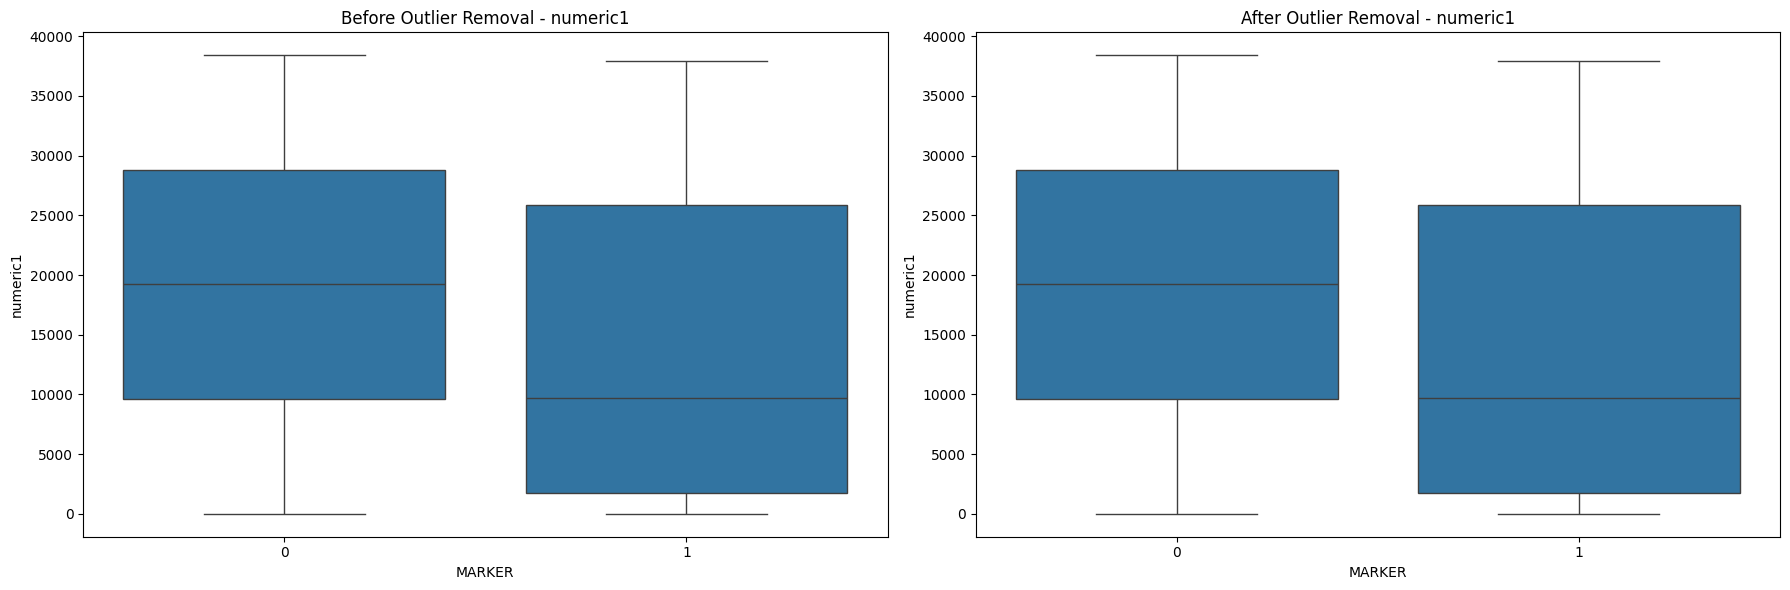

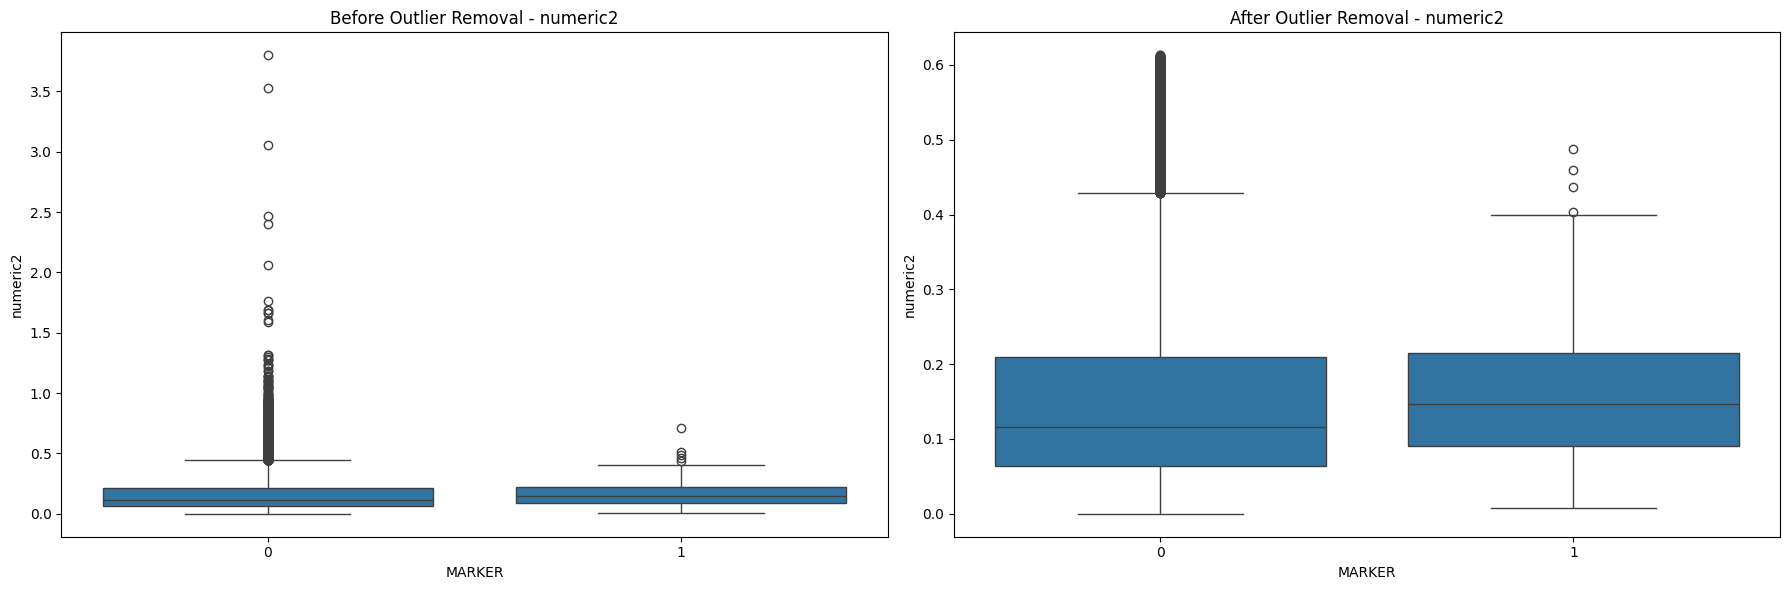

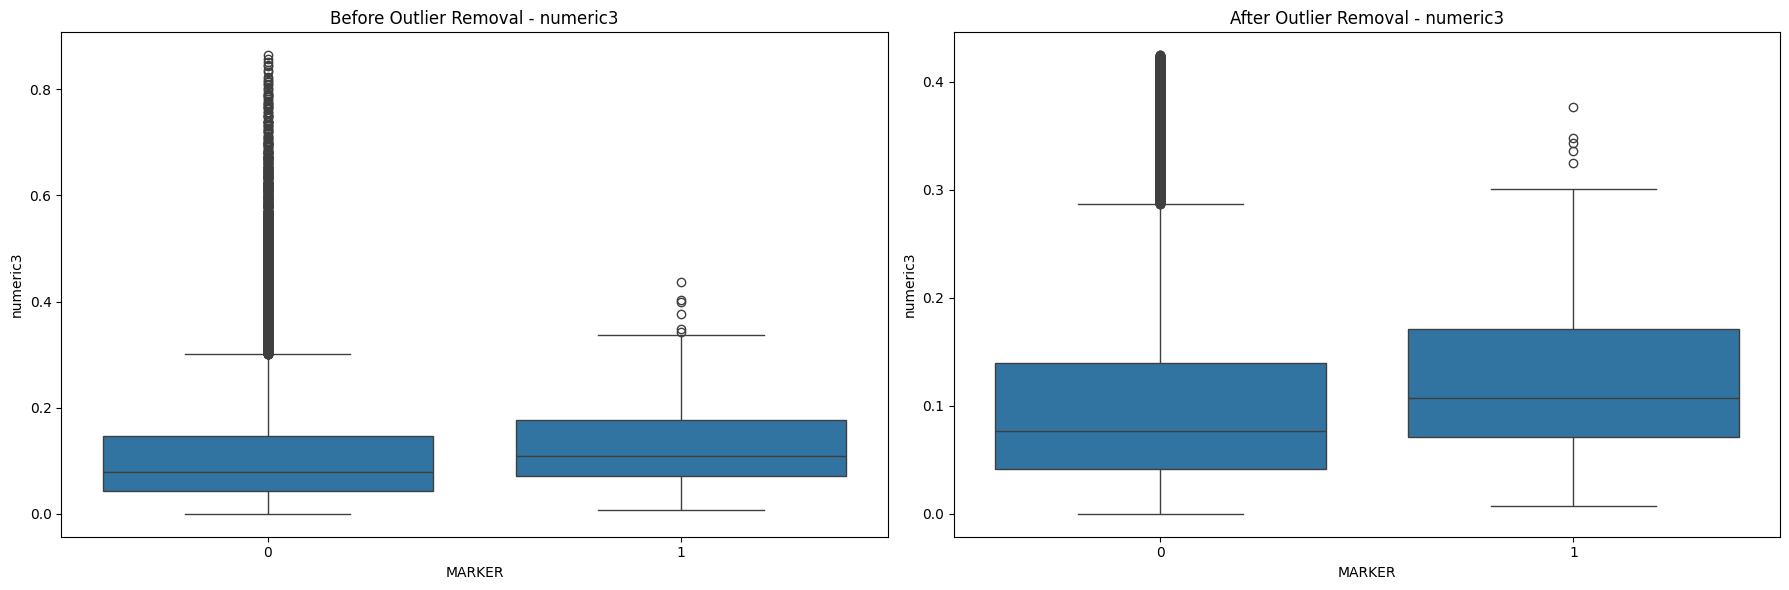

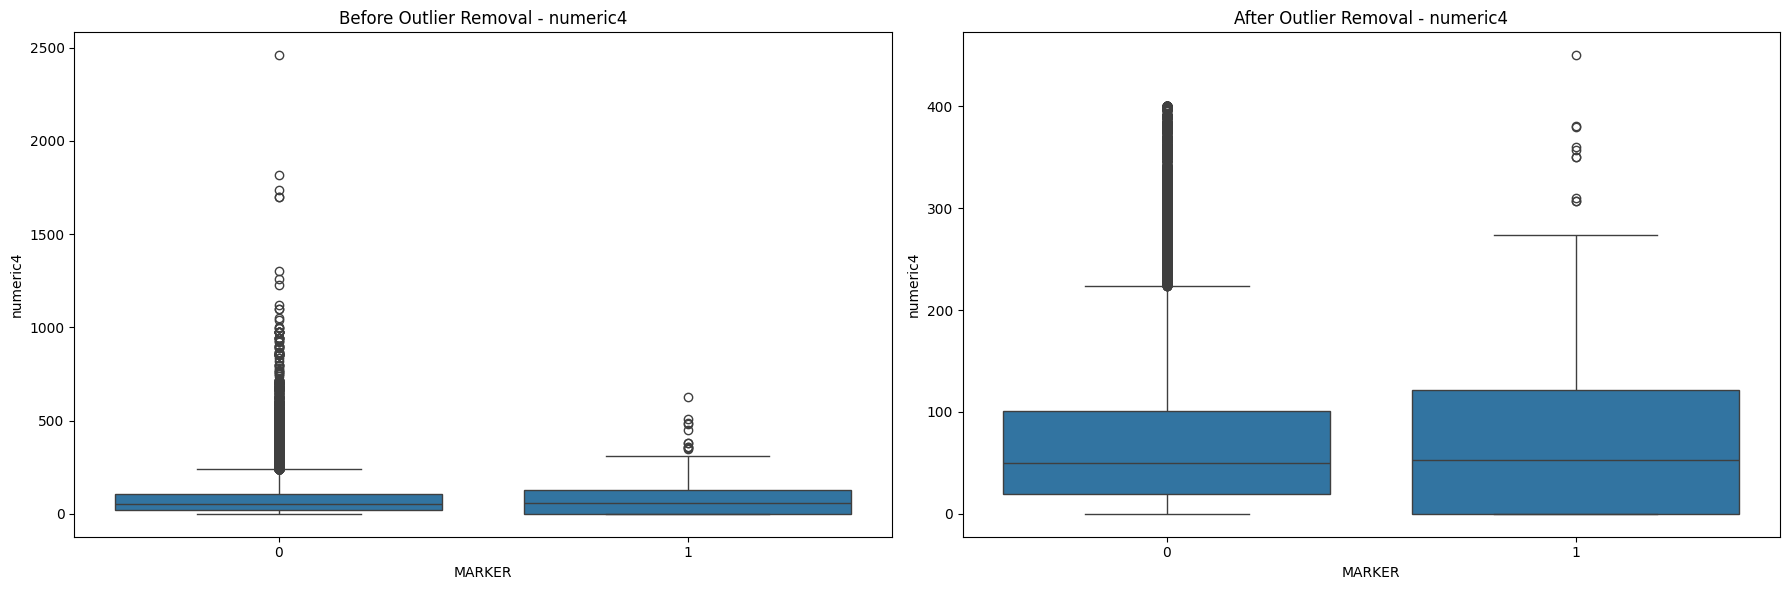

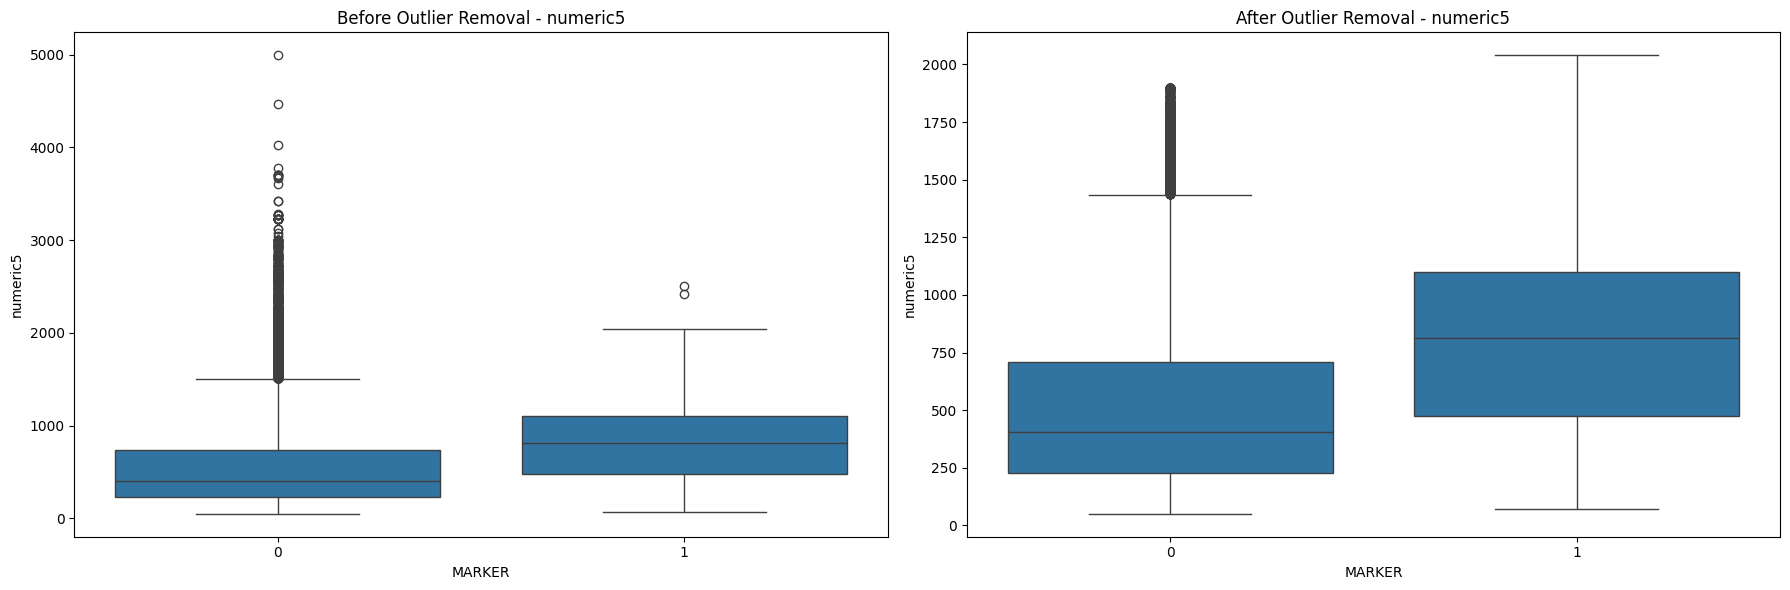

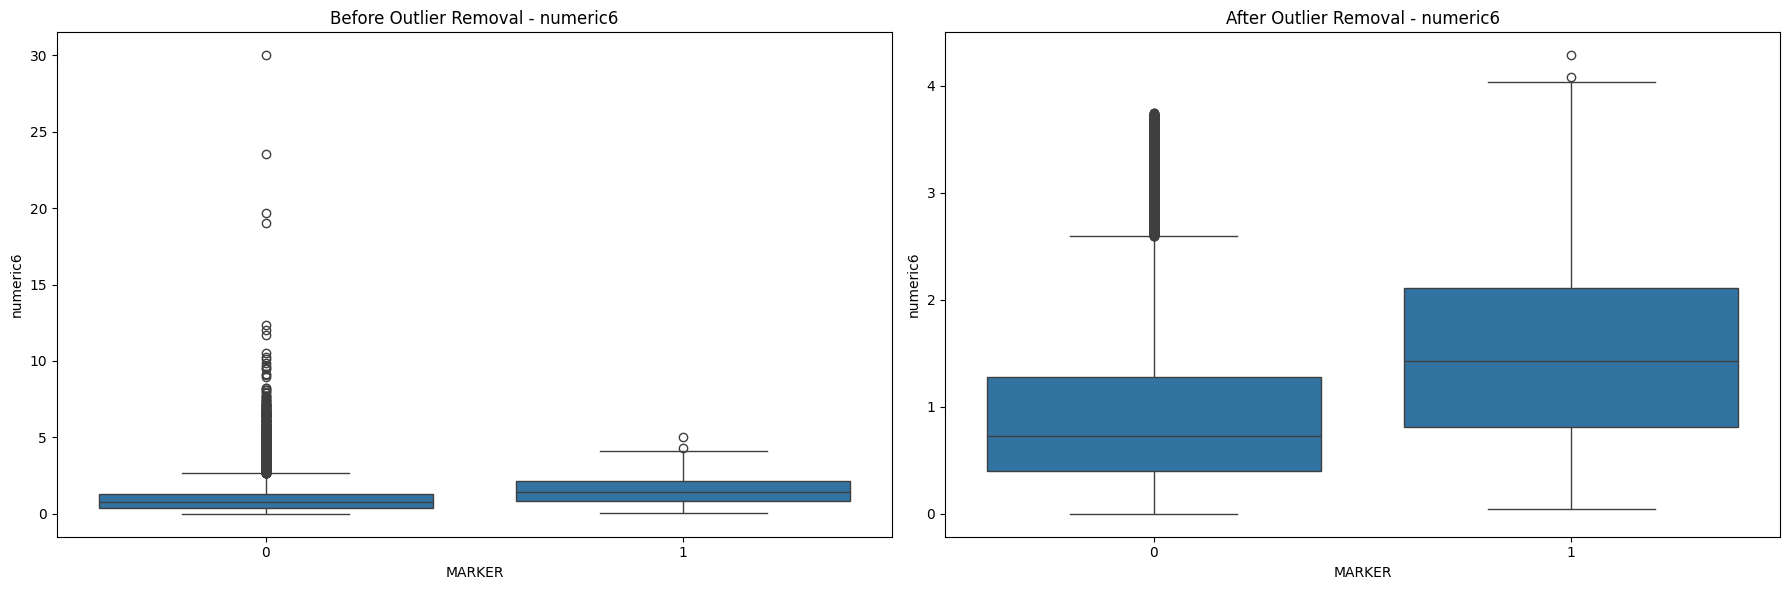

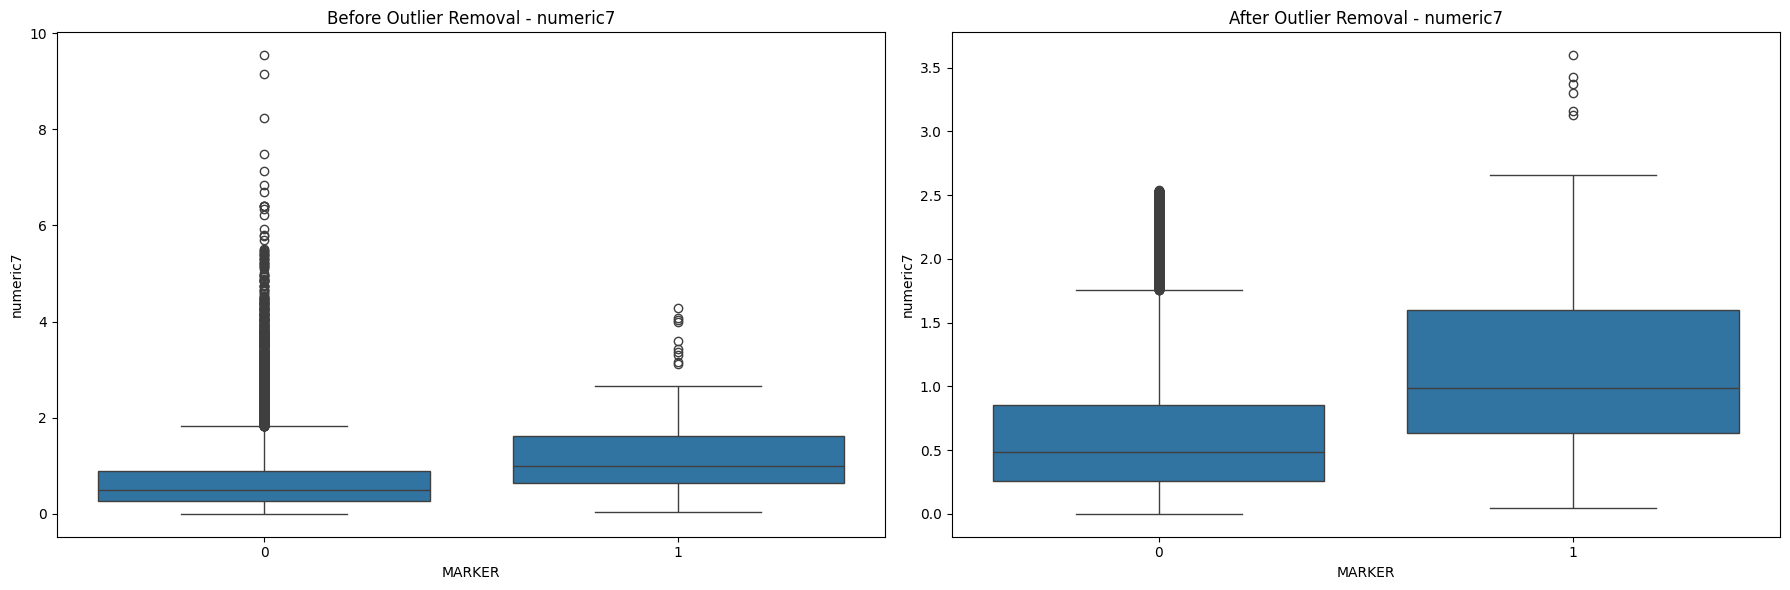

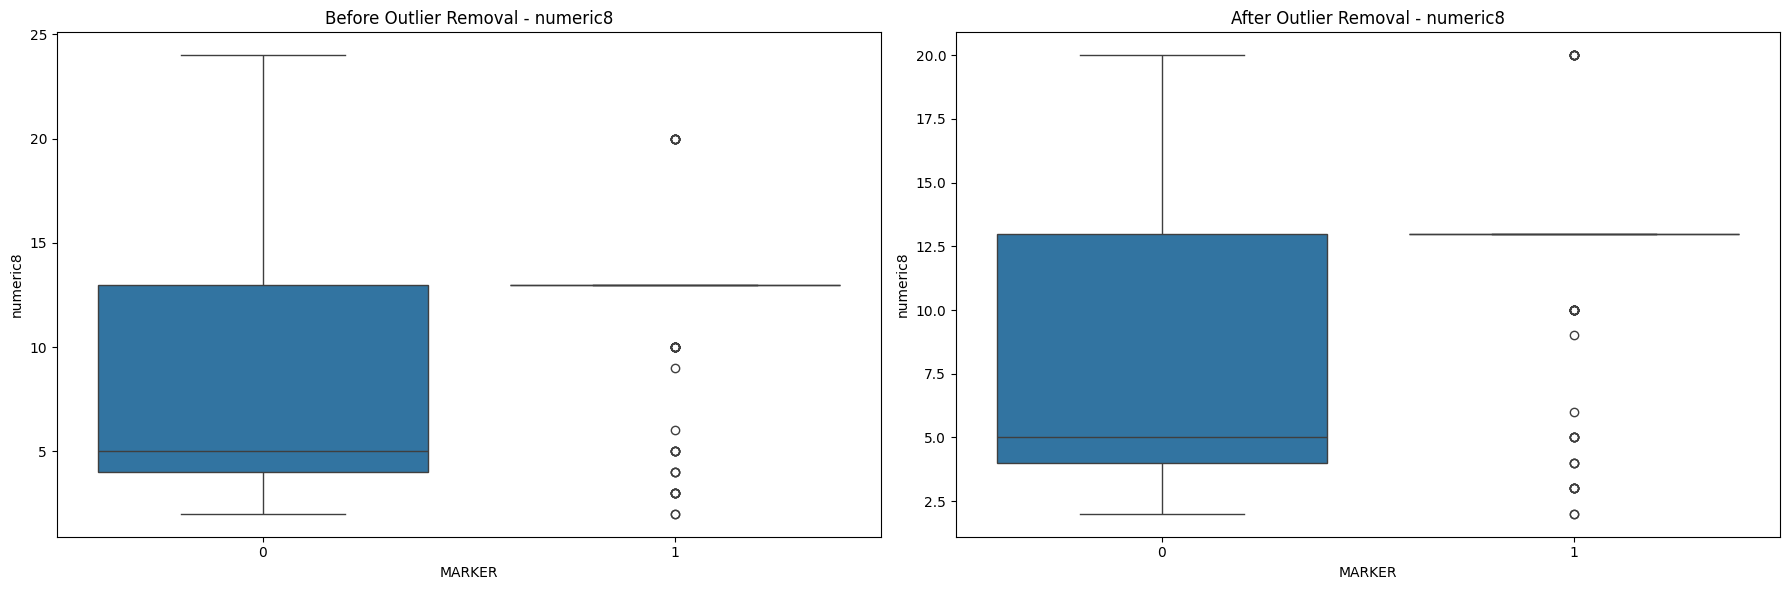

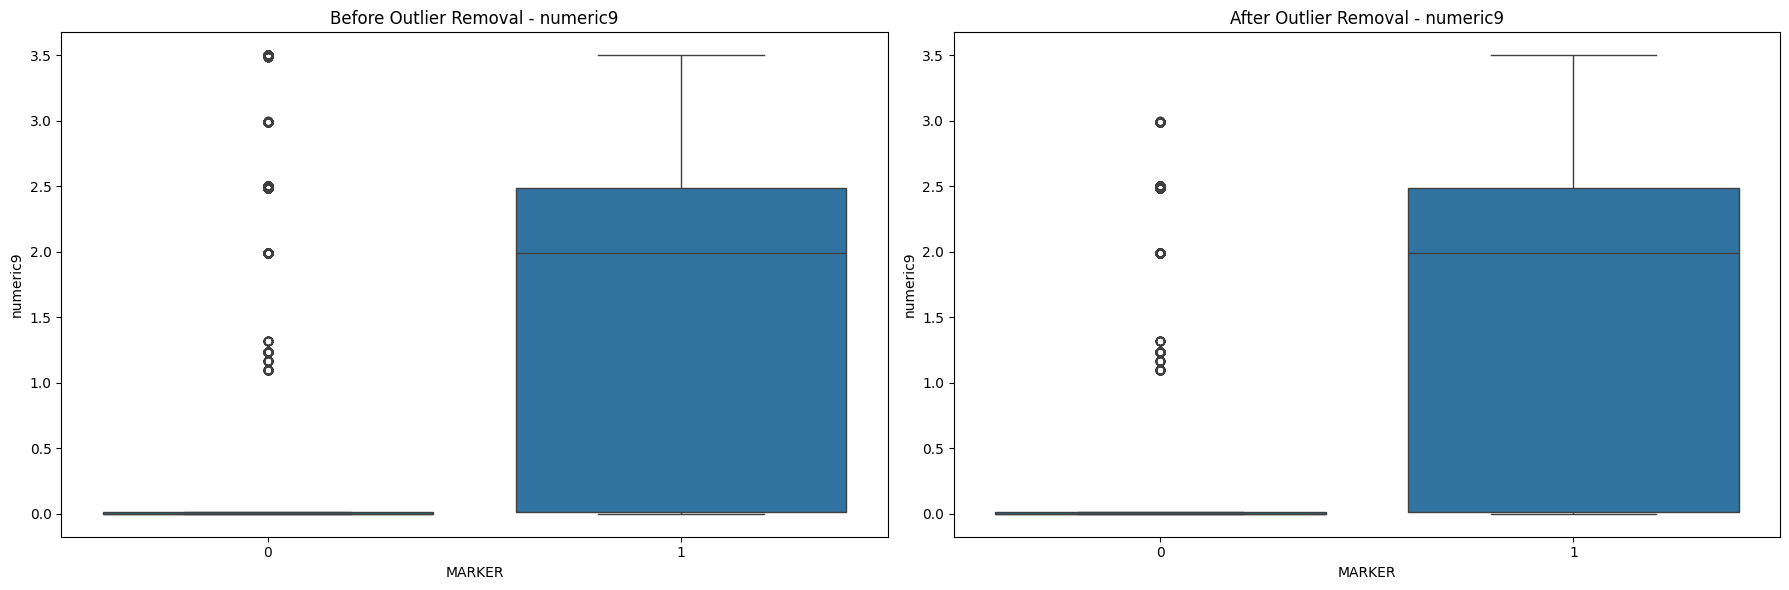

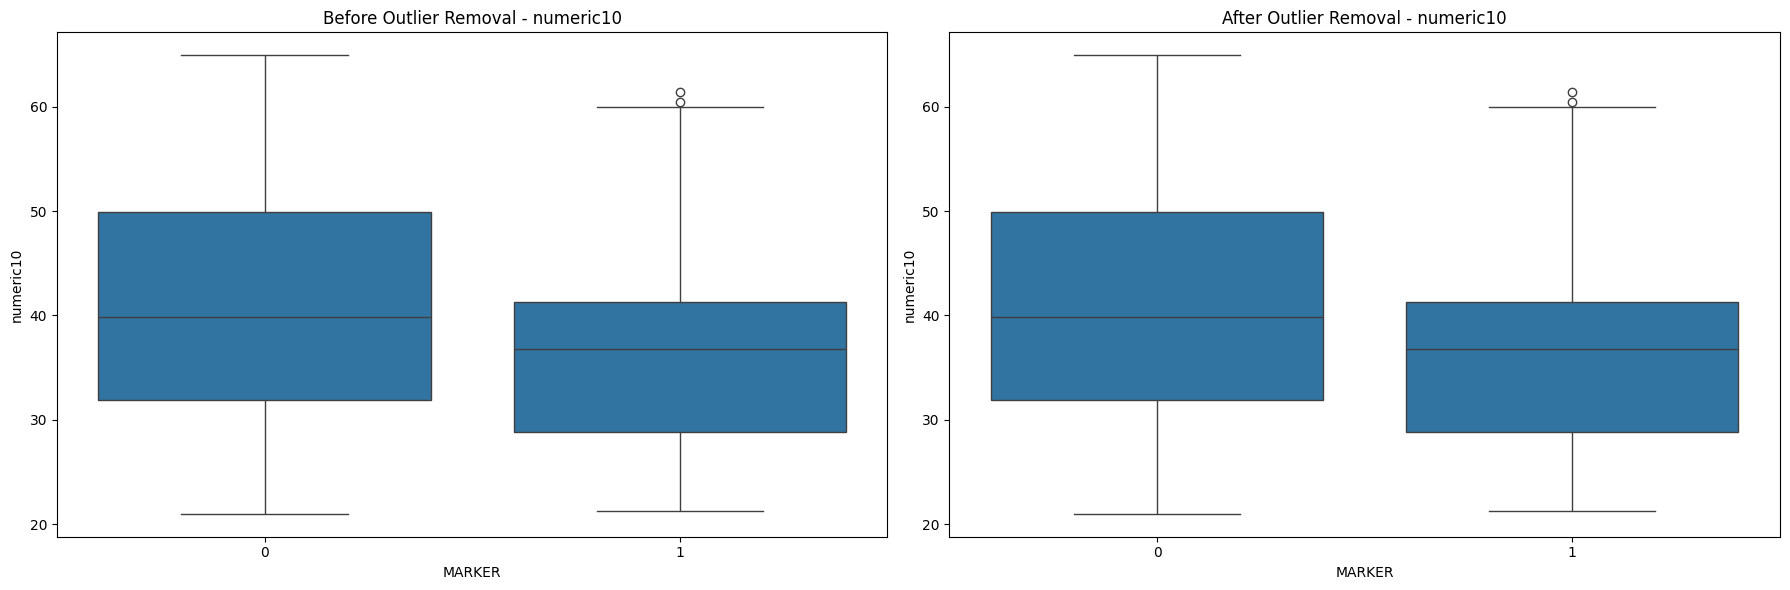

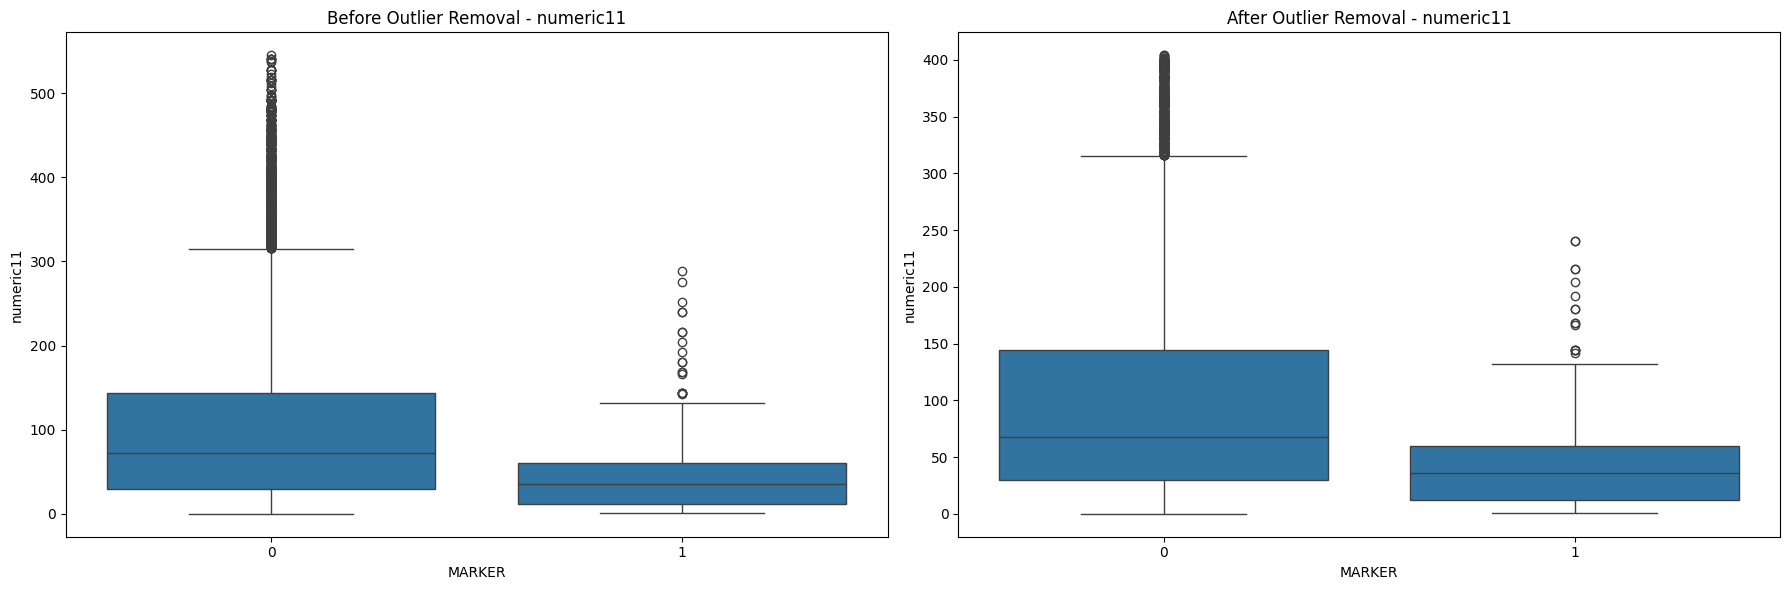

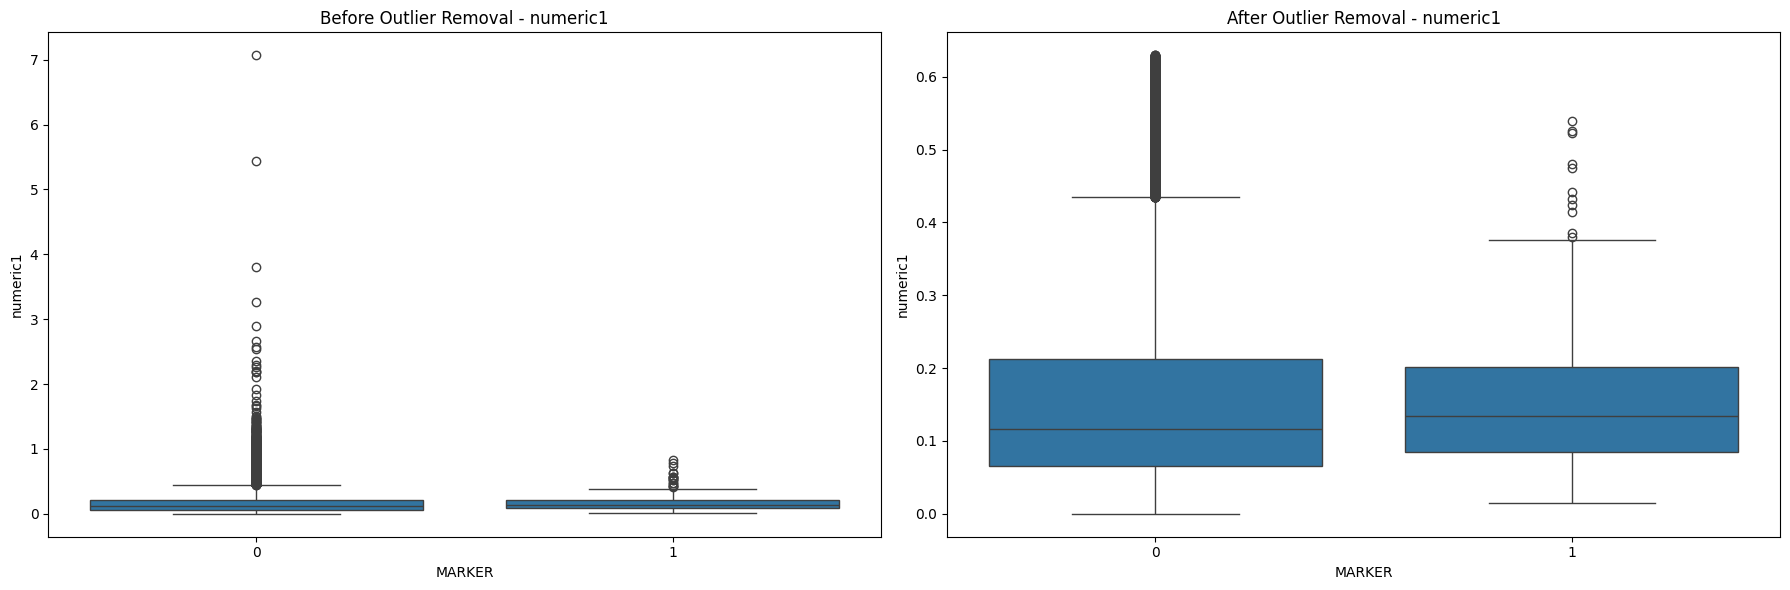

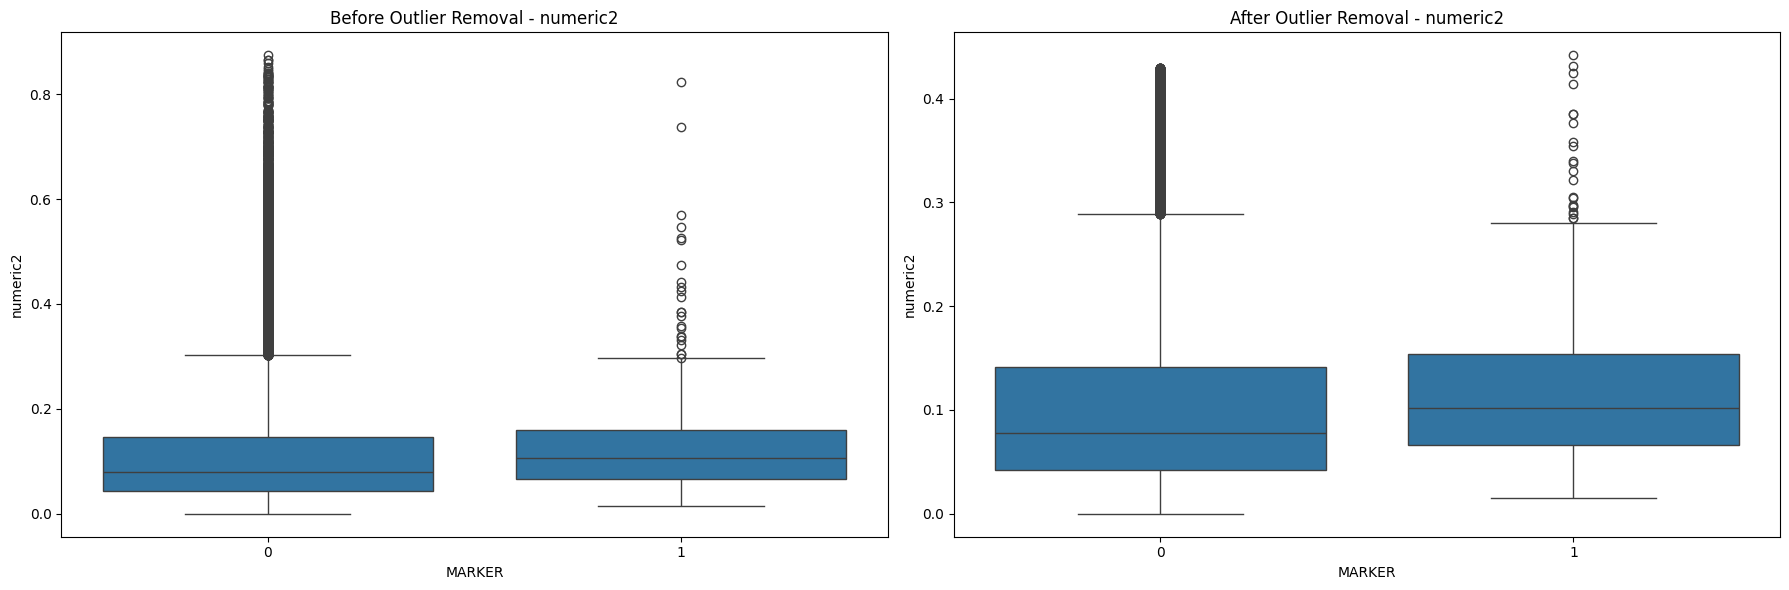

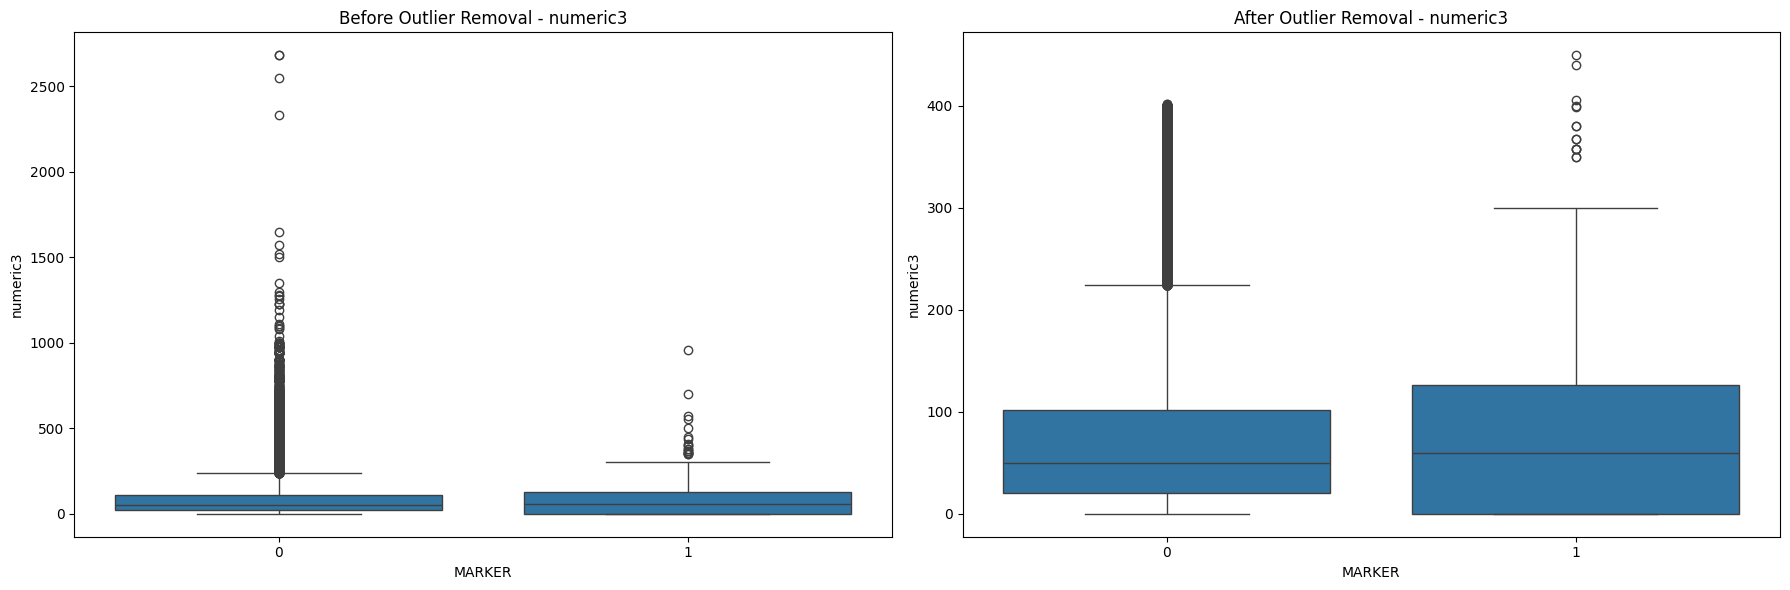

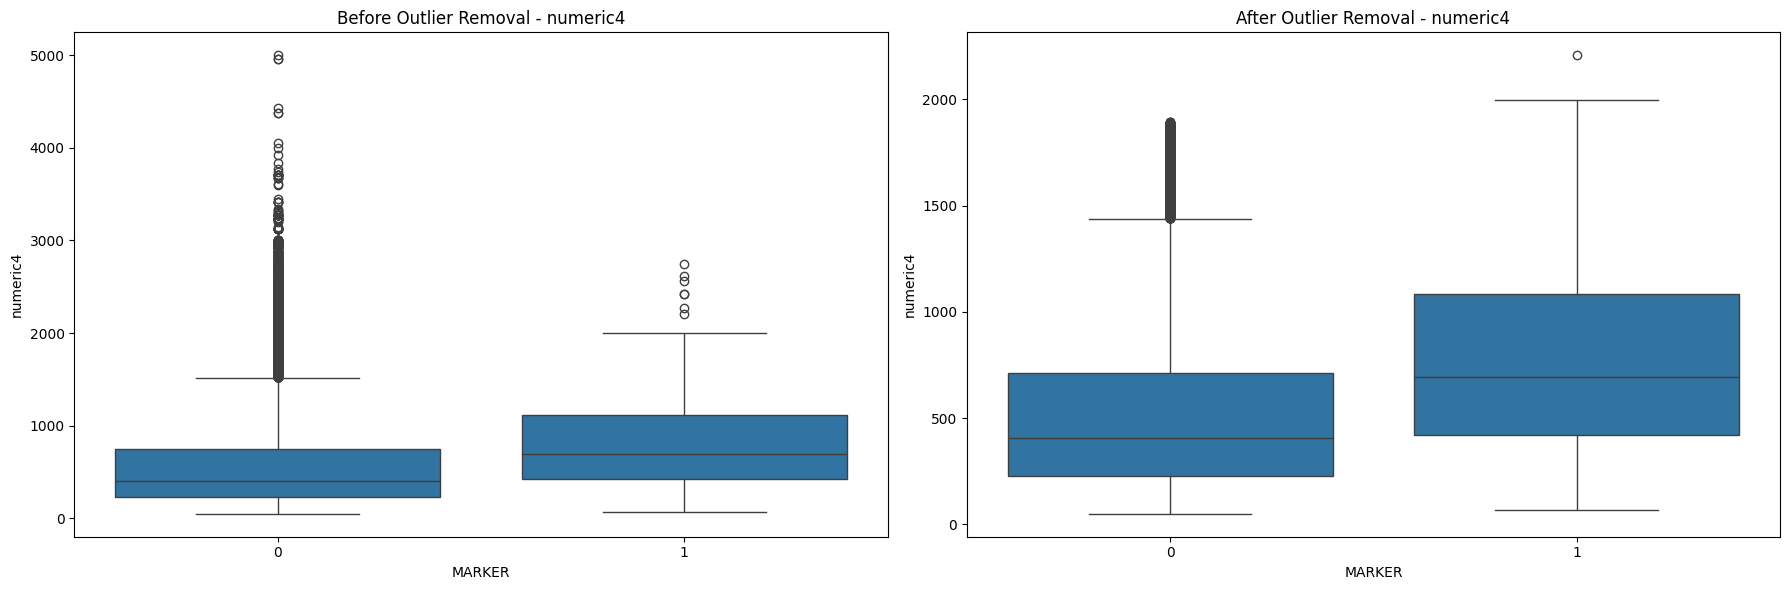

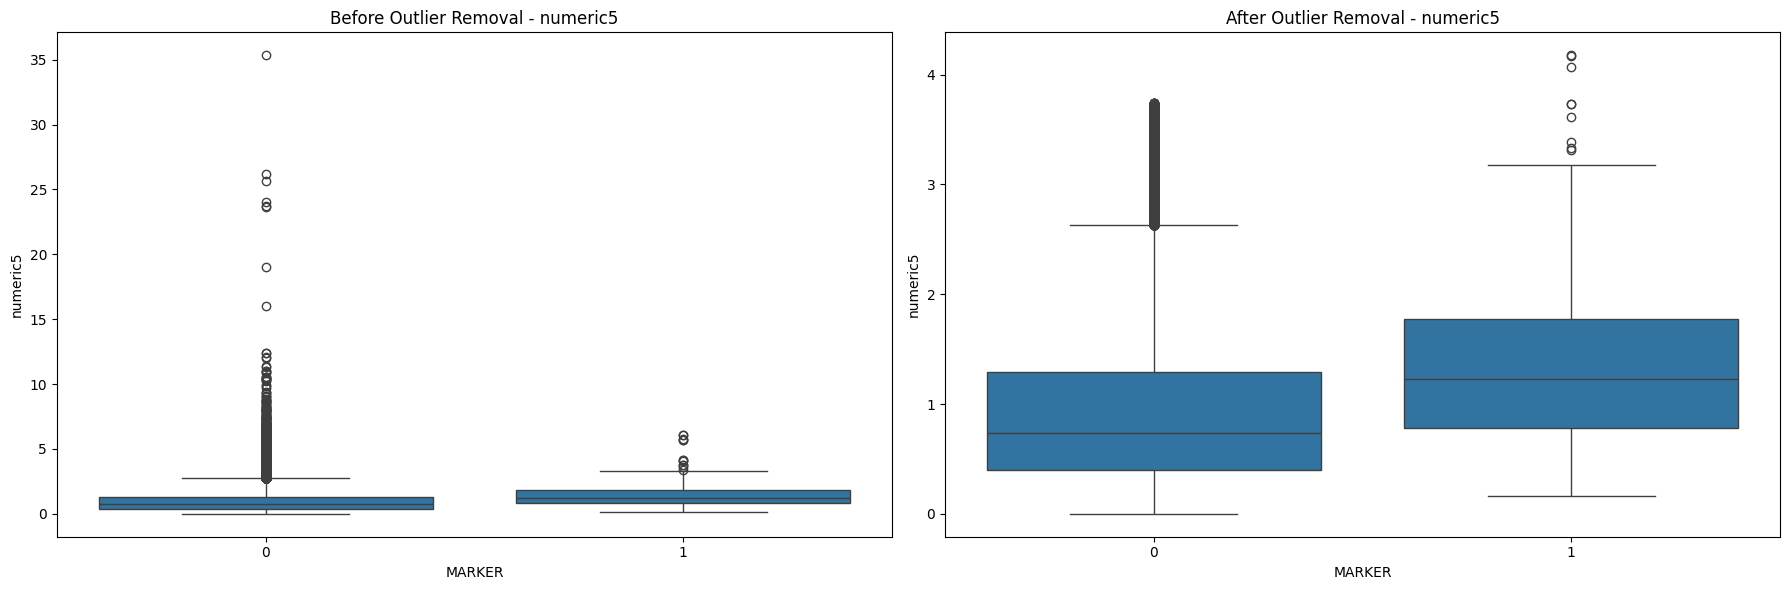

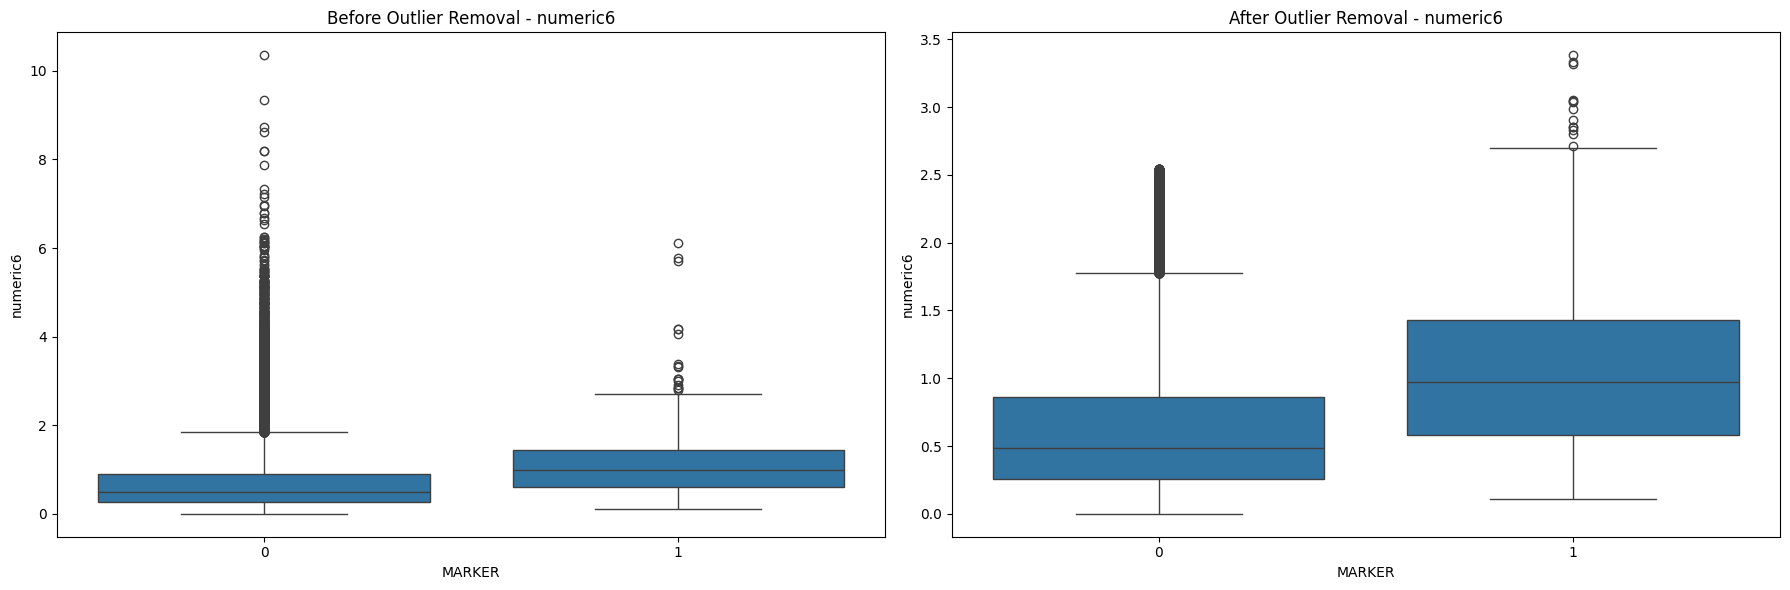

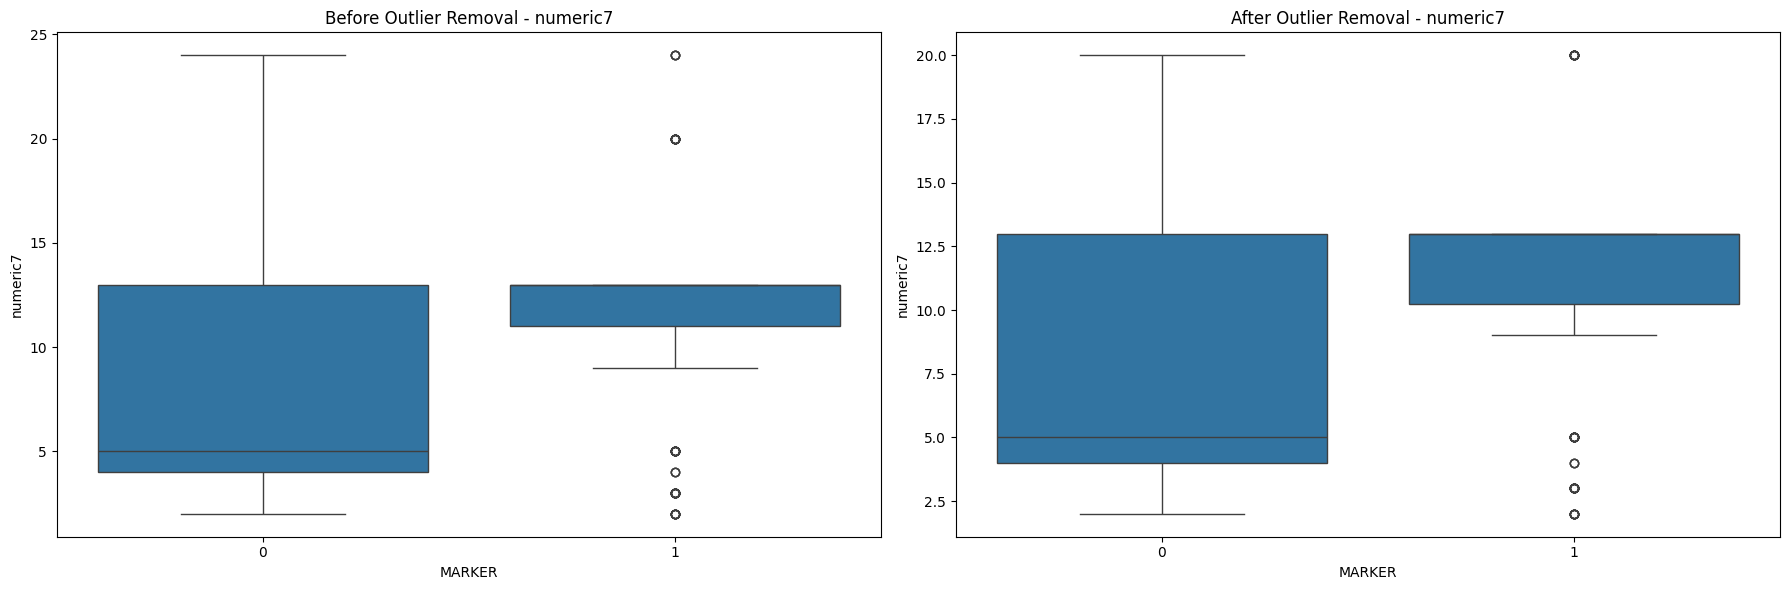

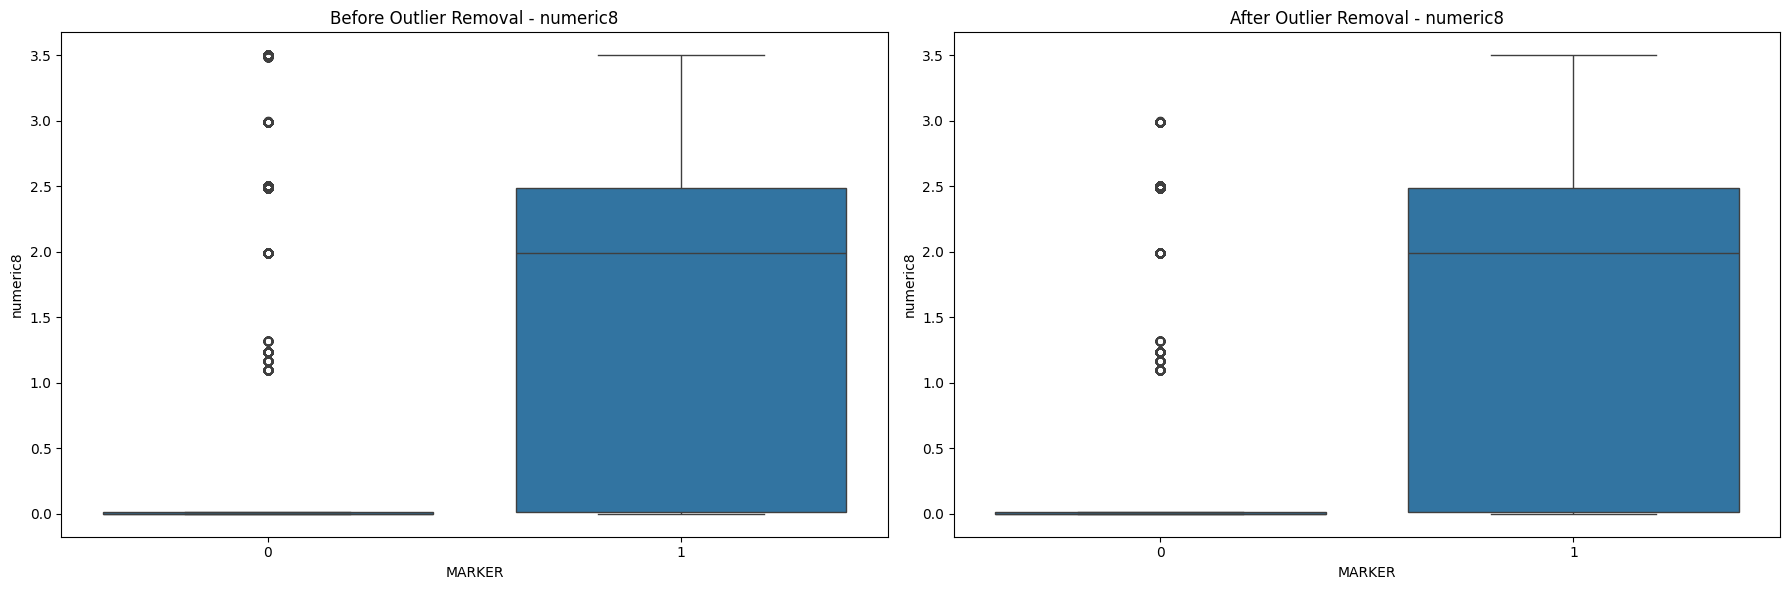

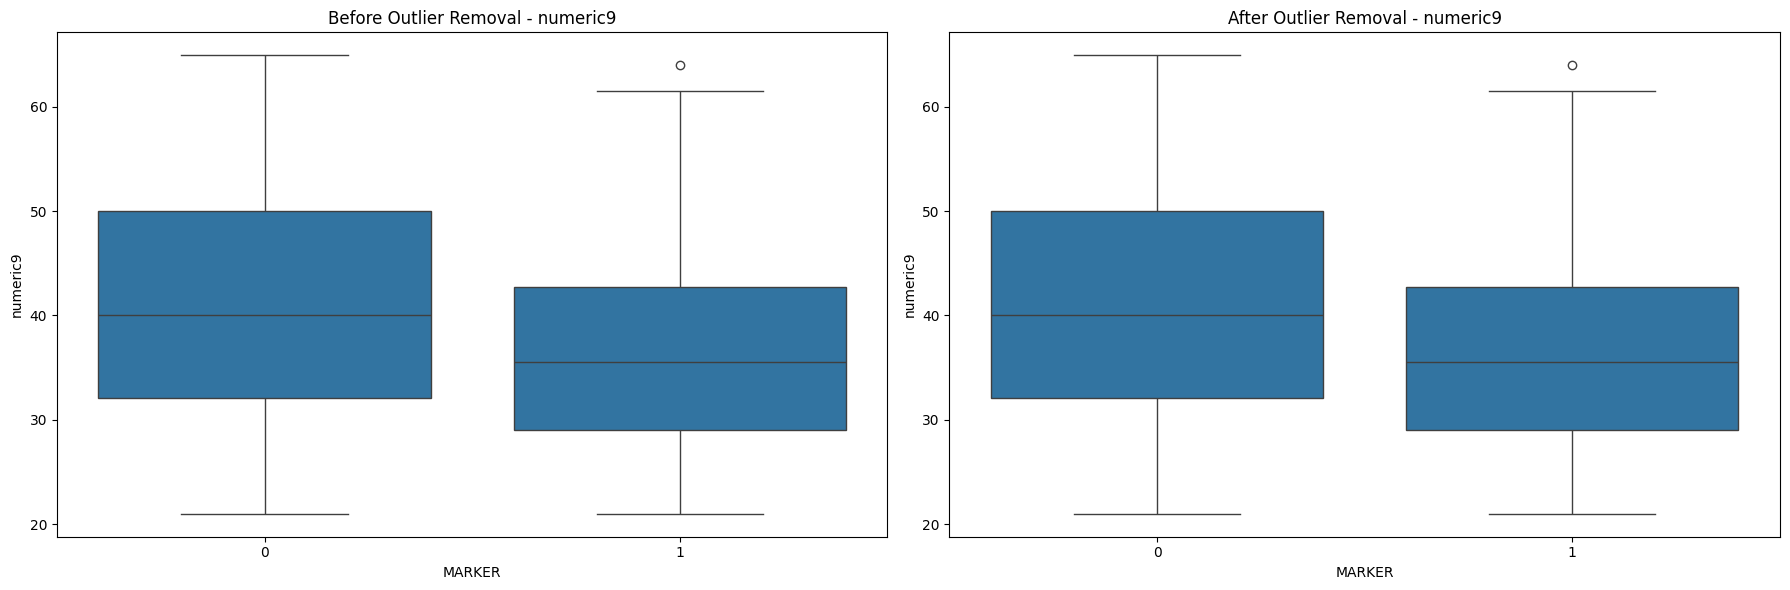

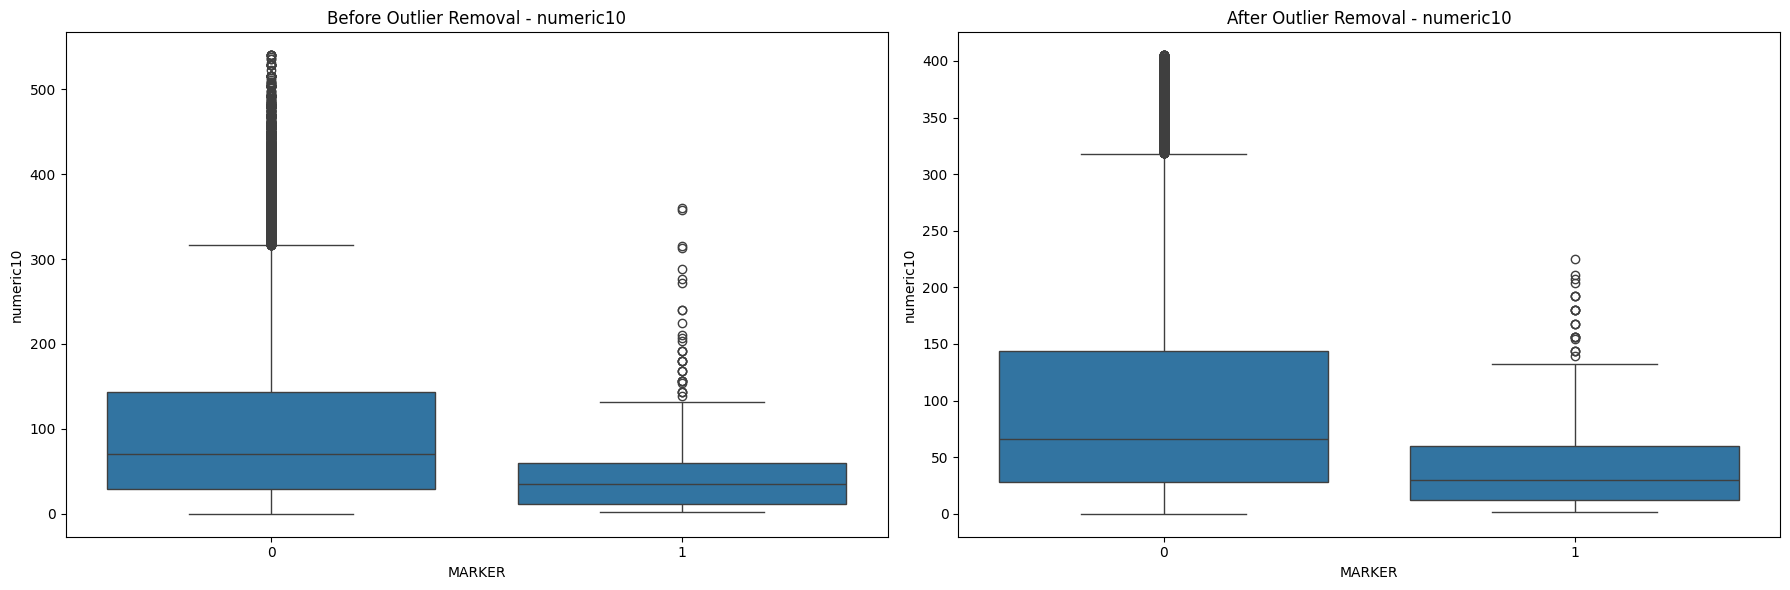

In [13]:
remove_outliers_visualization(data)

In [14]:
data['Training'].shape

(88341, 25)

In [15]:
# advanced filter

# def markov_probability_tresh(data, prob=0.03):
#     """
#         Parameters:
#          - data -> list of numerical values X_i >= 0
#          - prob -> probability, that occurence will exceed the threshold
         
#         Returns:
#          - thresh -> threshold, that satisfy P(x >= thresh; data) <= prob
#     """
#     assert len(list(filter(lambda el: el < 0.0, data))) == 0, "Series should satisfy non-negative value range"
    
#     data_mean = np.mean(data)
#     return data_mean / prob

# def remove_outliers(data):
#     to_filter = []
#     for df_name, df in data.items():
#         cols_to_filter = df.columns[(df.dtypes != 'object') & (~df.columns.isin(['ID', 'MARKER']))].tolist()
#         #print(cols_to_filter)
#         candidates = [] 
#         for col in cols_to_filter:
#             candidates.append((df_name, col,))
#         to_filter.extend(candidates)
    
#     fig, axs = plt.subplots(1,len(to_filter), figsize=(18, 4))
#     for idx, (tbl, col) in enumerate(to_filter):
#         vals = list(filter(lambda x: x > 0, data[tbl][col].to_numpy().flatten()))
        
#         is_log = max(vals) - min(vals) > 1e3
        
#         sns.histplot(data=np.log10(vals) if is_log else vals, ax=axs[idx]).set_title(f'Histogram of {"log" if is_log else None}_{col} in {tbl}')
#         for perc in [0.01, 0.005, 0.001]:
#             print(f"[{tbl} | {col}] Markov thresh on {100 * perc}%: {markov_probability_tresh(vals, prob=perc)}")

## Выгрузка очищенных данных

In [16]:
%%time
# add path to load 
dirpath = os.getcwd()
path_to_load = Path(dirpath) / 'clean_data'
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in data.items():
    filepath = path_to_load / filename
    with open(filepath, mode='w', newline='') as file:
        df.to_csv(filepath, index=False)

CPU times: total: 969 ms
Wall time: 1.04 s


In [17]:
# check for correct saving
print(*[f+"\n" for f in os.listdir(path_to_load) if os.path.isfile(os.path.join(path_to_load, f))])

Test
 Training



# EDA

## Чтение очищенных данных

In [18]:
%%time

# get directory path
dirpath = os.getcwd()
clean_data_path = Path(dirpath) /'clean_data'


# load data to dict
data = {}
for file_path in clean_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(filepath)
        print(file_path.stem)

Test
Training
CPU times: total: 375 ms
Wall time: 435 ms


## Исследование распределений

In [19]:
# calc preparation
numeric_df = data['Training'][data['Training'].select_dtypes(include=[np.number]).columns].copy()
numdata_class1 = numeric_df[numeric_df['MARKER'] == 1]
numdata_class0 = numeric_df[numeric_df['MARKER'] == 0]
num_columns = numeric_df.drop(['MARKER'], axis=1).columns
print(numeric_df.columns)
print(num_columns)

Index(['numeric1', 'numeric2', 'numeric3', 'numeric4', 'numeric5', 'numeric6', 'numeric7', 'numeric8', 'numeric9', 'numeric10', 'MARKER'], dtype='object')
Index(['numeric1', 'numeric2', 'numeric3', 'numeric4', 'numeric5', 'numeric6', 'numeric7', 'numeric8', 'numeric9', 'numeric10'], dtype='object')


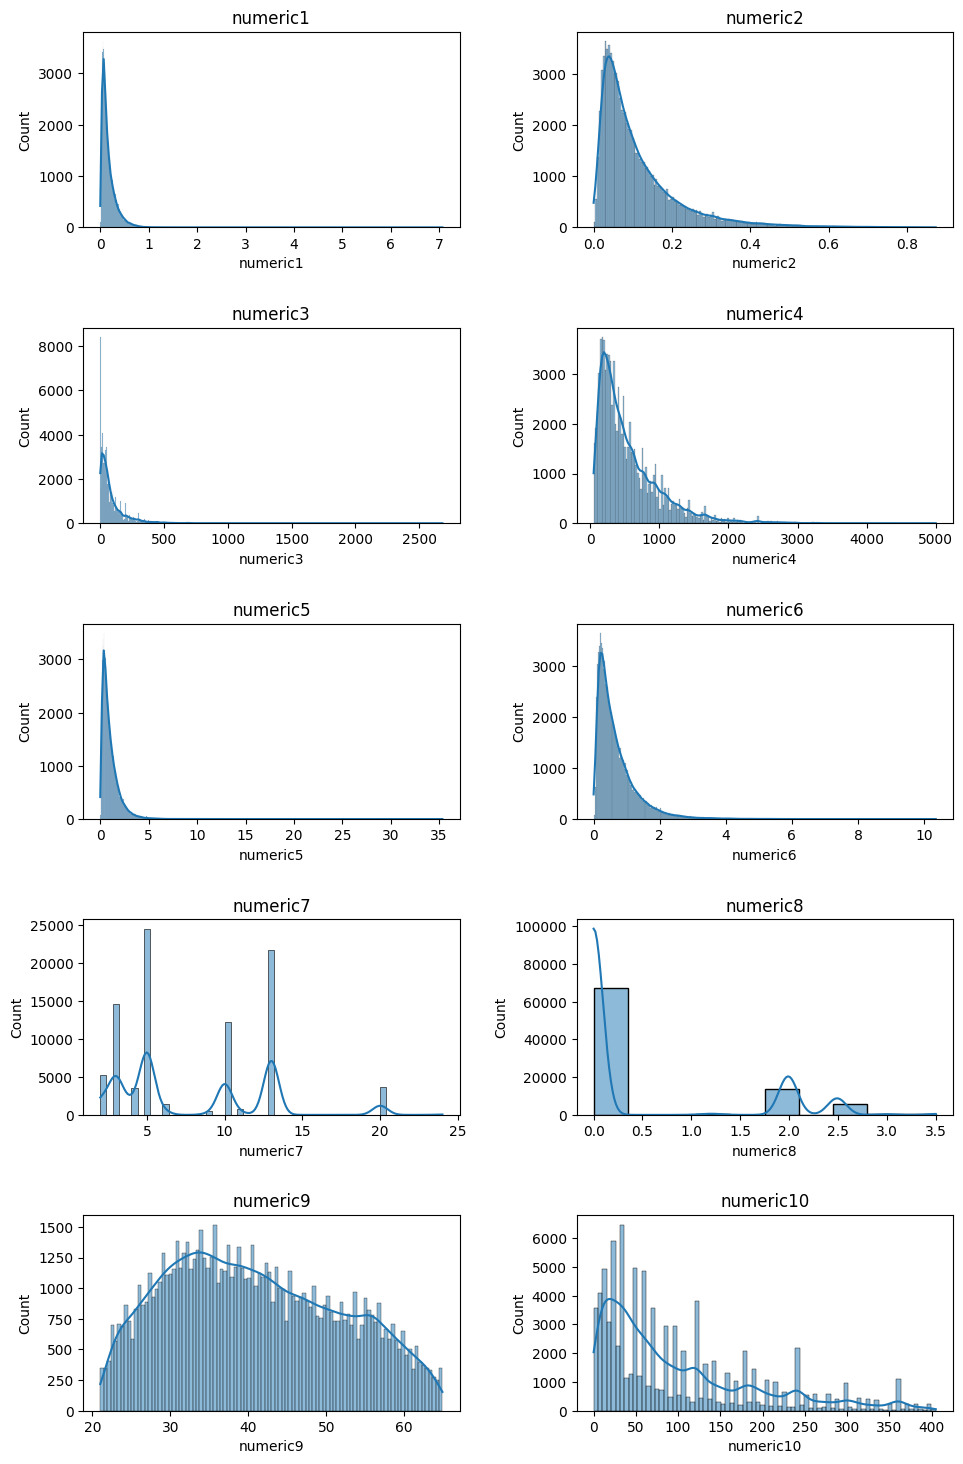

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, column in enumerate(num_columns):
    row, col = divmod(i, 2)
    if column == "numeric8":
        sns.histplot(numeric_df[column], ax=axes[row, col], kde=True, bins=10)
    elif column == "numeric9":
        sns.histplot(numeric_df[column], ax=axes[row, col], kde=True, bins=100)
    else:
        sns.histplot(numeric_df[column], ax=axes[row, col], kde=True)
    axes[row, col].set_title(column)
    axes[row, col].set_xlim(auto=True)
    axes[row, col].set_ylim(auto=True)
    
plt.tight_layout(pad=2, h_pad=2.5)
plt.show()

* Из распредлений видно, что большинство принадлежит экспоненциальному семейству (№ 1, 2, 3, 4, 5, 6, 10 - некоторые в  большей, некоторые в меньше степени). К таким признакам будет применяться логарифмирование с целью попыток приведения их к нормальному распределению, для увелечинения линейной корреляции числовых и  таргетной переменных. Также некоторые модели ( например логистическая регрессия) качественнее обучатся на нормально распределенных данных.
* Признаки 7 и 8 представляют собой дискретные распределения - такие признаки можно либо сразу интерпретировать, как encoded, либо поробовать применить кластеризацию и посмотреть на корреляцию полученных кластеров с таргетом, если корреляция улучшится по сравнению с некластеризованными - значит в ней будет смысл.
* Распределение признака 9 поохоже на что-то между экспоненциальным и нормальным распределением. Его также можно будет попробовать логарифмировать и посмотреть на изменения.

### Экспоненциальные признаки

In [21]:
from scipy.stats import gamma, norm, probplot
columns_to_log = [1, 2, 3, 4, 5, 6, 9, 10]

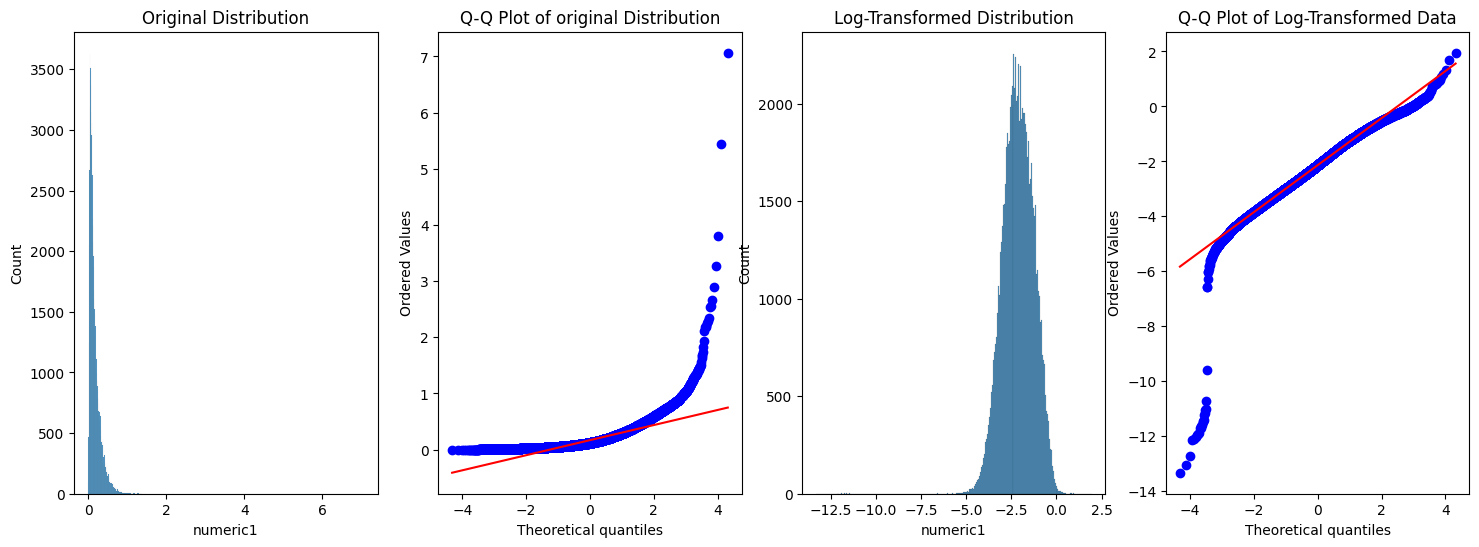

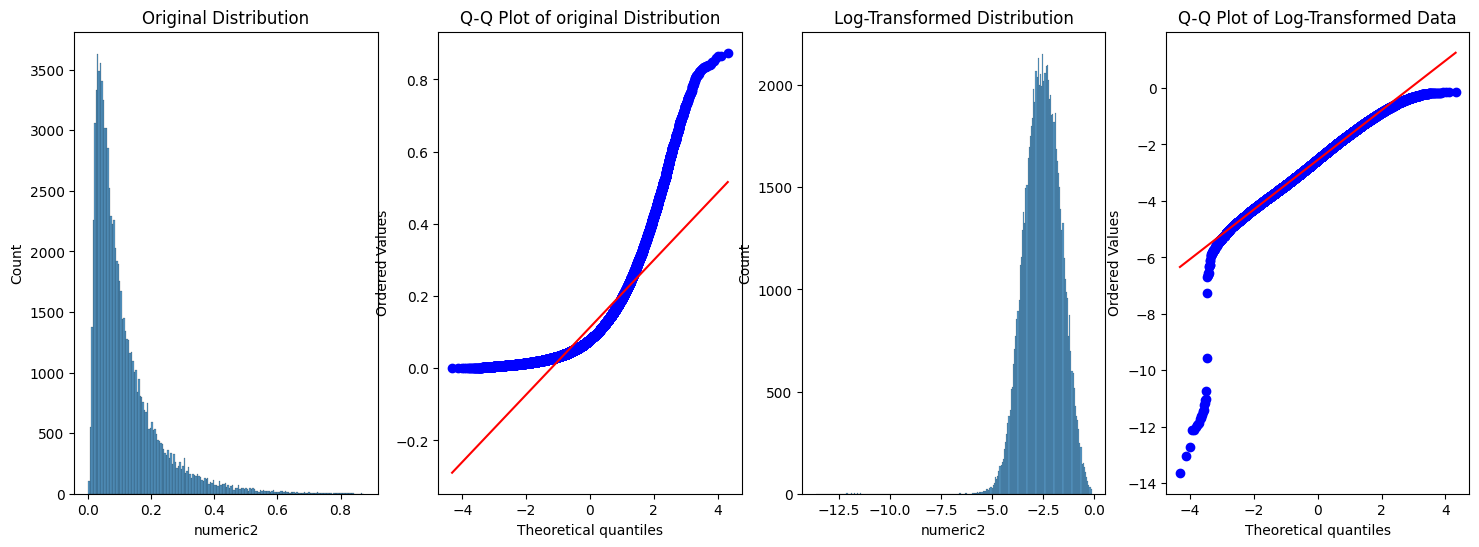

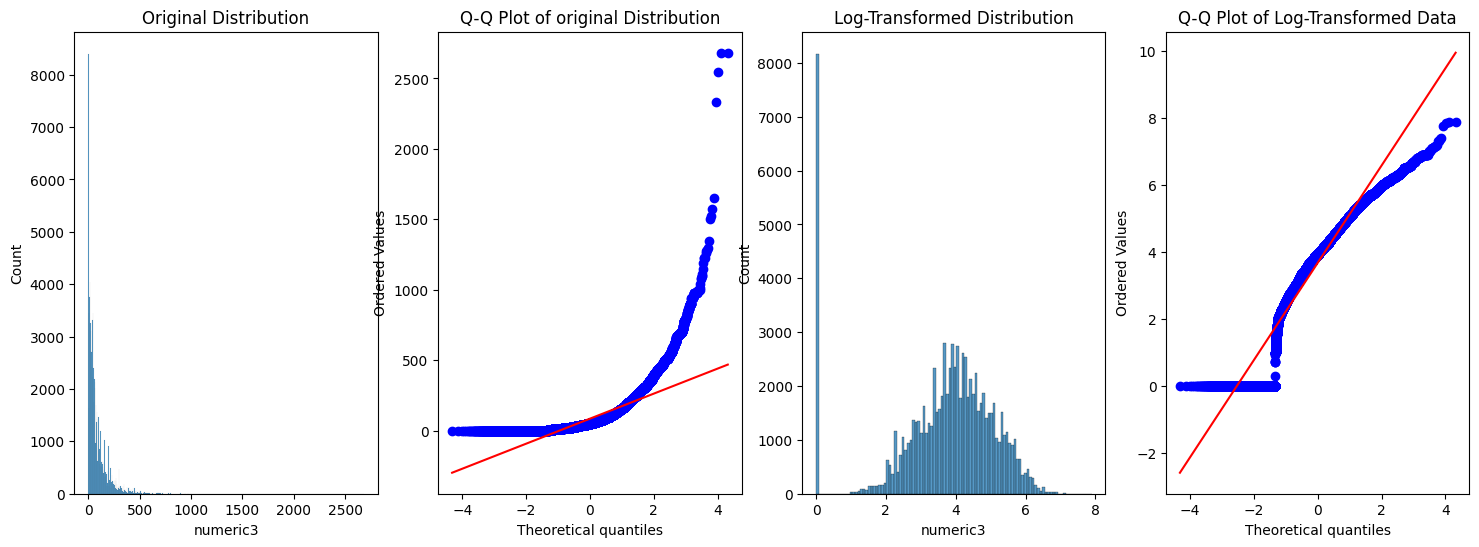

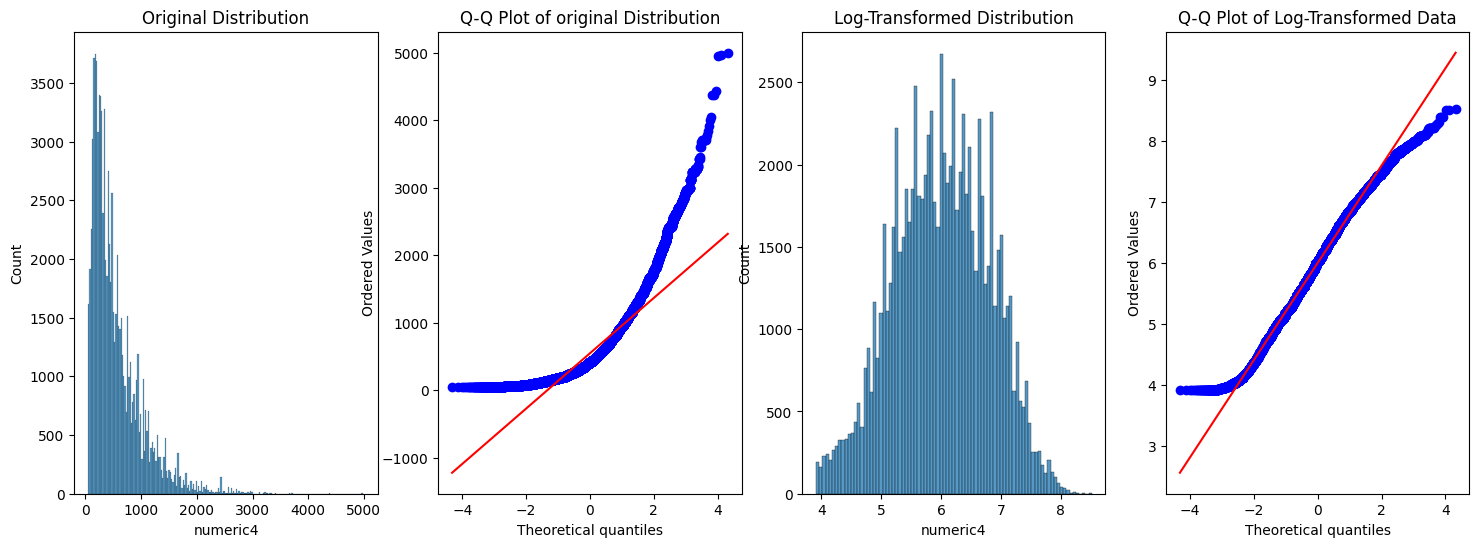

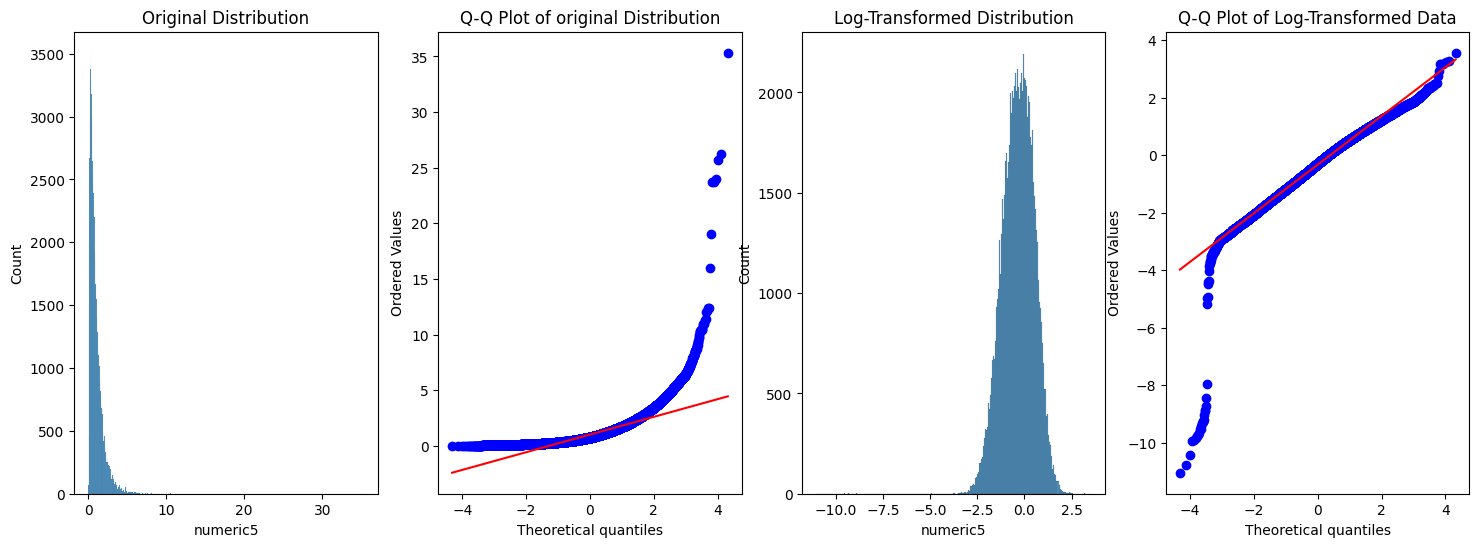

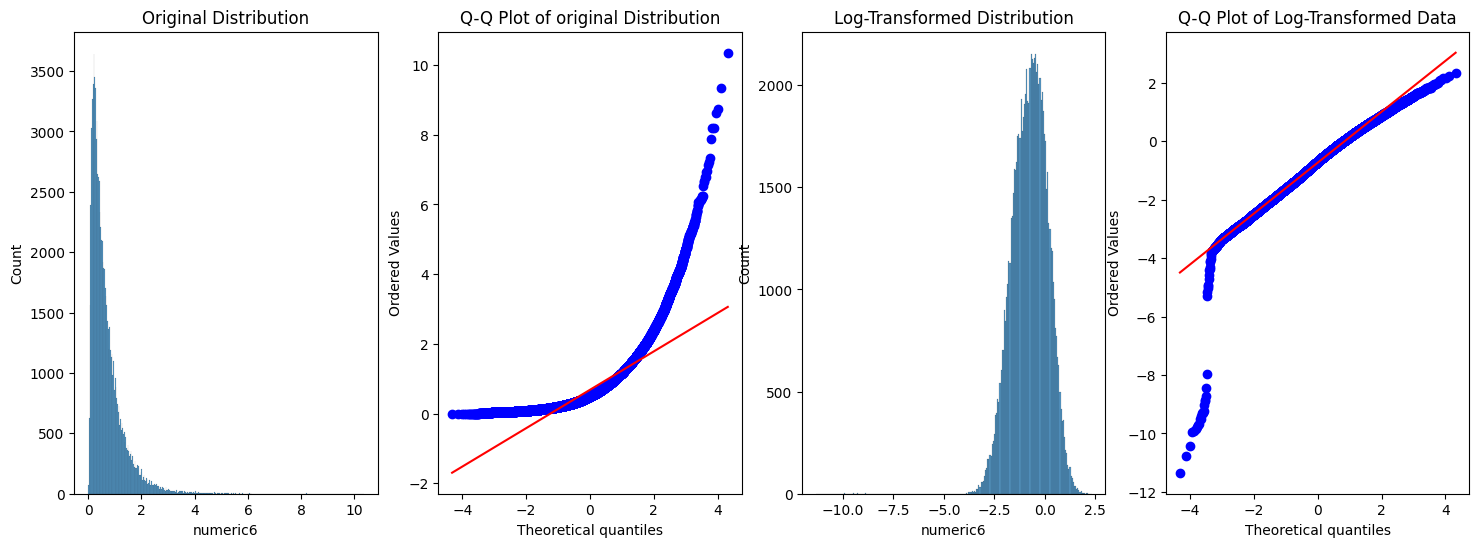

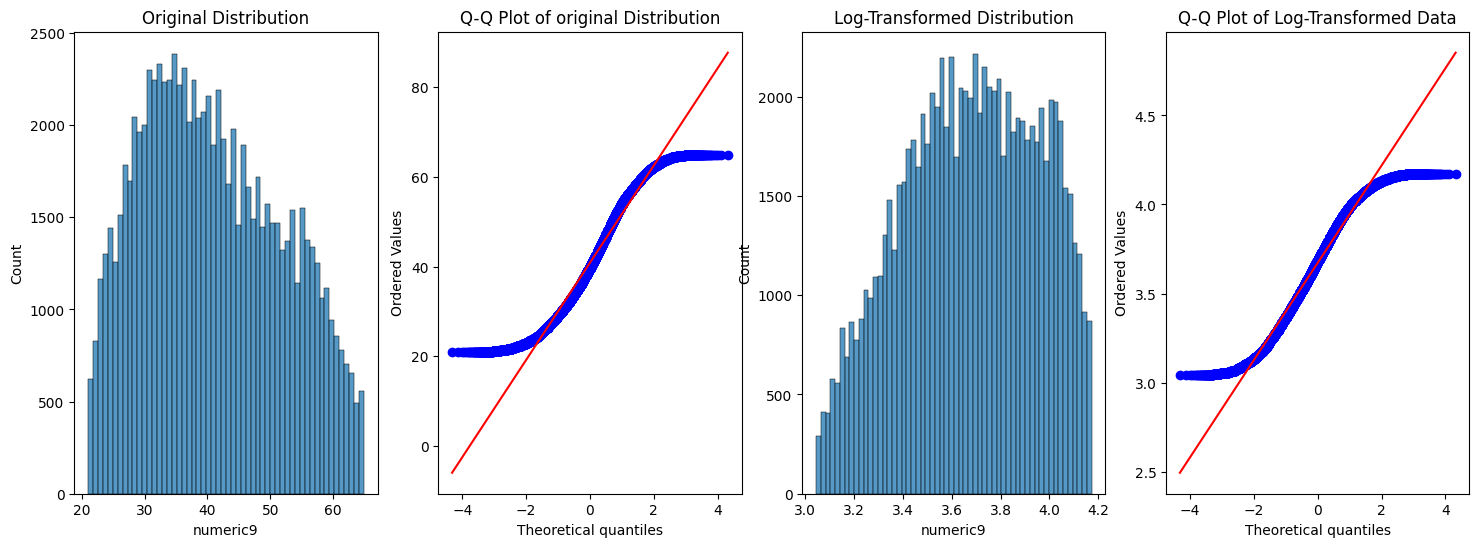

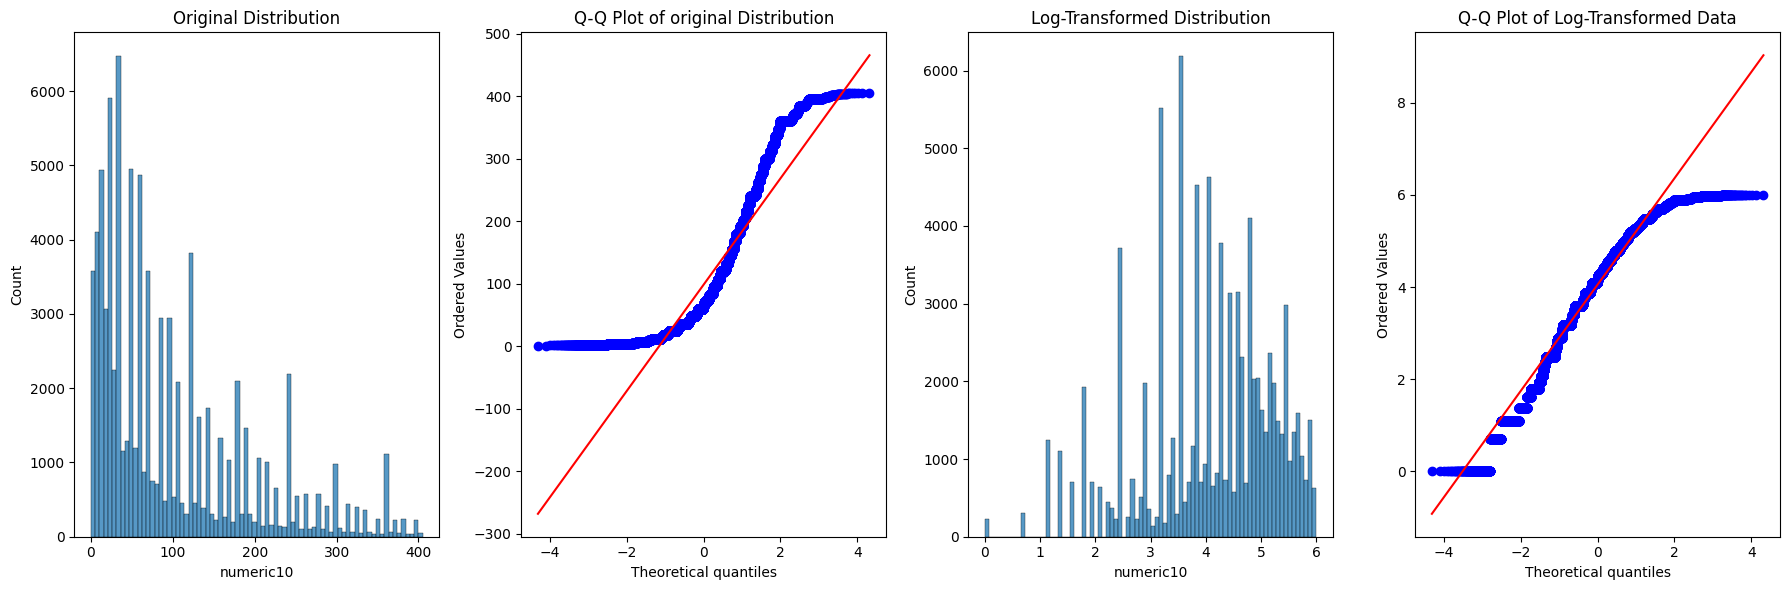

In [22]:
for col_num in columns_to_log:
    col = f'numeric{col_num}'
    plt.figure(figsize=(18, 6))
    
    # Оригинал
    plt.subplot(1, 4, 1)
    sns.histplot(numeric_df[col])
    plt.title('Original Distribution')
    
    # Q-Q plot оригинала
    plt.subplot(1, 4, 2)
    probplot(numeric_df[col], dist="norm", plot=plt)
    plt.title('Q-Q Plot of original Distribution')
    
    # Логарифмическое преобразование
    numeric_df[col] = numeric_df[col].apply(lambda x: np.log(x) if x != 0 else 0)
    
    # Логарифмически преобразованное распределение
    plt.subplot(1, 4, 3)
    sns.histplot(numeric_df[col])
    #p = norm.pdf(x, np.mean(log_col), np.std(log_col))
    #plt.plot(x, p, 'k', linewidth=2)
    plt.title('Log-Transformed Distribution')
    
    # Q-Q plot для проверки нормальности
    plt.subplot(1, 4, 4)
    probplot(numeric_df[col], dist="norm", plot=plt)
    plt.title('Q-Q Plot of Log-Transformed Data')

plt.tight_layout()
plt.show()

По гистограммам и Q-Q графикам после логарифмирования можно наблюдать, что распределения признаков стали близки к нормальным, что и было целью данного преобразования.

### Дискретные признаки

Необходимость кластеризации можно оценить, сгруппировав по уникальным значениям признака и посмотрев, как соотносятся люди которые ушли в дефолт

In [23]:
count1 = numdata_class1.shape[0]
count0 = numdata_class0.shape[0]

# Аггрегация для numeric7
counts_numeric7 = numeric_df.groupby('numeric7')['MARKER'].agg([
    pd.Series.count,
    lambda x: sum(x == 1),
    lambda x: sum(x == 0),
    lambda x: sum(x == 1) / count1 * 100,
    lambda x: sum(x == 0) / count0 * 100
])
counts_numeric7.columns = ['count_numeric7', 'count_class_label_1', 'count_class_label_0', 'perc_class_label_1', 'perc_class_label_0']

# Аггрегация для numeric8
counts_numeric8 = numeric_df.groupby('numeric8')['MARKER'].agg([
    pd.Series.count,
    lambda x: sum(x == 1),
    lambda x: sum(x == 0),
    lambda x: sum(x == 1) / count1 * 100,
    lambda x: sum(x == 0) / count0 * 100
])

counts_numeric8.columns = ['count_numeric8', 'count_class_label_1', 'count_class_label_0', 'perc_class_label_1', 'perc_class_label_0']

In [24]:
counts_numeric7

count_numeric7  count_class_label_1  count_class_label_0  perc_class_label_1  perc_class_label_0
numeric7                                                                                                  
2                   5182                    8                 5174            2.402402            5.879011
3                  14593                   21                14572            6.306306           16.557586
4                   3508                    3                 3505            0.900901            3.982592
5                  24470                   15                24455            4.504505           27.787247
6                   1495                    0                 1495            0.000000            1.698709
9                    500                    2                  498            0.600601            0.565858
10                 12254                   34                12220           10.210210           13.885101
11                   791                    2                  789            0.600601            0.896509
13                 21729                  231                21498           69.369369           24.427325
20                  3670                   13                 3657            3.903904            4.155304
24                   149                    4                  145            1.201201            0.164758

In [25]:
counts_numeric8

count_numeric8  count_class_label_1  count_class_label_0  perc_class_label_1  perc_class_label_0
numeric8                                                                                                  
0.000              62293                   83                62210           24.924925           70.686756
0.010               5038                   17                 5021            5.105105            5.705163
1.100                113                    0                  113            0.000000            0.128397
1.170                108                    1                  107            0.300300            0.121580
1.235                230                    1                  229            0.300300            0.260204
1.320                 49                    0                   49            0.000000            0.055677
1.990              13928                  114                13814           34.234234           15.696300
2.490               5714                   91                 5623           27.327327            6.389192
2.500                277                    8                  269            2.402402            0.305654
2.990                253                   11                  242            3.303303            0.274975
3.000                  1                    0                    1            0.000000            0.001136
3.490                 42                    1                   41            0.300300            0.046587
3.500                295                    6                  289            1.801802            0.328379

Есть значения, в которых один класс в процентном соотношении значительно преобладает над другим, но таких случаев не особо много. Можно будет попробовать кластеризацию, для их объединения.

## Корреляционный анализ

<Axes: >

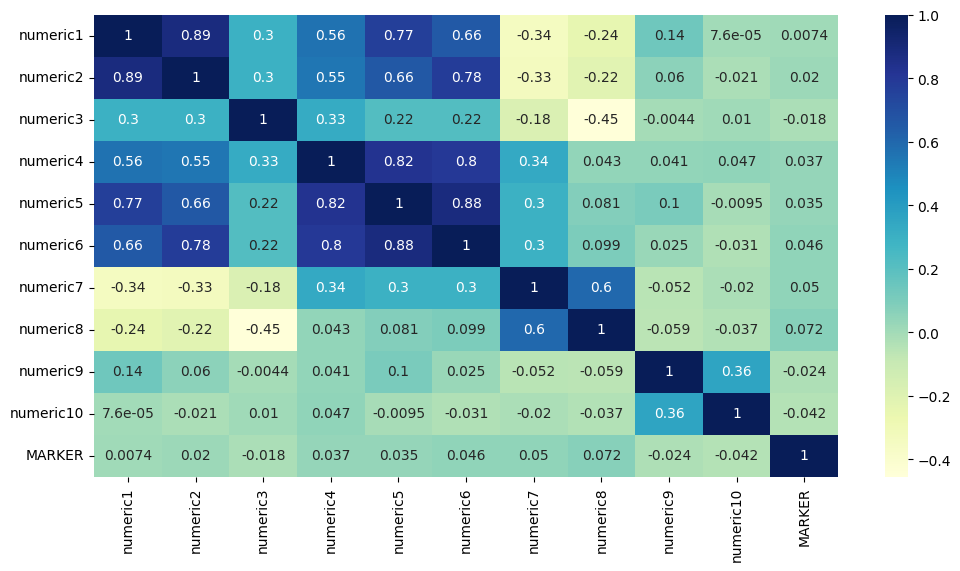

In [26]:
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="YlGnBu")

* Данные очень сильно коррелируют между собой. Если не обработать коррелирующие признаки, при обучении будут проблемы с мультиколлинеарностью.
* Признаки плохо коррелируют с таргеной перменной, что странно. Нужно посмотреть на распределение таргетной переменной.

<Axes: xlabel='MARKER', ylabel='Count'>

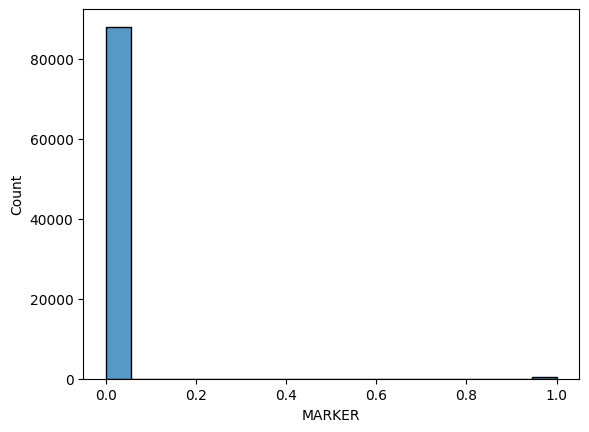

In [27]:
sns.histplot(df['MARKER'])

In [28]:
print(numeric_df['MARKER'].sum() / numeric_df['MARKER'].count() * 100)

0.3769484157978742


* Количество данных с меткой класса 1 всего лишь 0.34% - нужно будет решать проблему несбалансированности классов.
* Наиболее вероятно, корреляция признаков с тагретной переменной видна плохо на тепловой карте из-за несбалансированности классов, нужно попробовать взять случайным образом такое же количество записей из класса 0, сколько имеется всего записей класса 1 и посмотреть на корреляцию снова, чтобы  не попасть на случайную неудачную выборку для класса 0, будет производится многоразовая случайная выборка и считаться средние значения корреляции.

<Axes: >

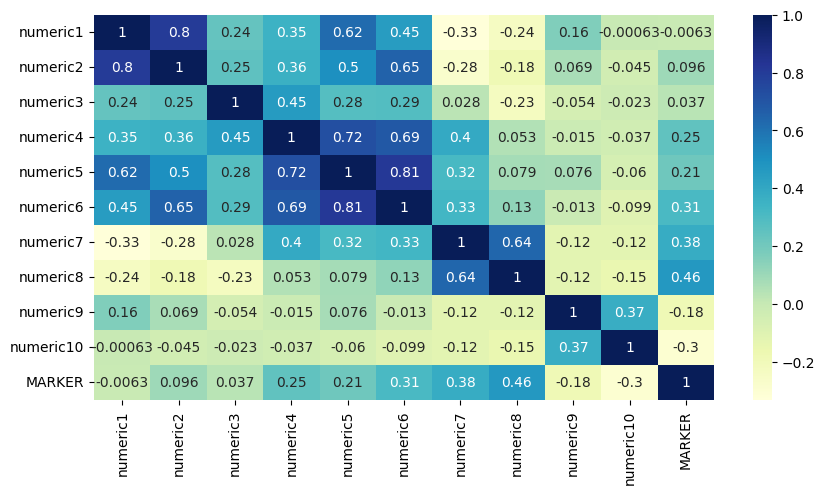

In [29]:
n = 2 * numdata_class1['MARKER'].sum()
corr_arr = []

# get samples and calc corr
for _ in range(1000):
    sample = numdata_class0.sample(n=n)
    concat_sample = pd.concat([sample, numdata_class1])
    corr_arr.append(concat_sample.corr().values)

# calc mean
corr_arr = np.array(corr_arr)
mean_corr = np.mean(corr_arr, axis=0)
mean_corr_df = pd.DataFrame(mean_corr, index=concat_sample.columns, columns=concat_sample.columns)

# visualize
plt.figure(figsize=(10, 5))
sns.heatmap(mean_corr_df, annot=True, cmap="YlGnBu")

* Как видим из графика, теперь наблюдаются неплохие корреляции для числовых признаков, с 4ого по 10ый.
* Всё также сохранилась проблема мультиколлинеарности, что говорит о том, что она не ложная (не из-за дисбаланса классов).
* Исходя из того, что были получены неплохие корреляции при малом количестве мажоритарного класса - неплохим решением будет попробовать многократный undersampling.

### Исходя из EDA можно заключить:
* Большинство признаков неплохо коррелируют с таргетной переменной
* Многие численные признаки нужно логарифмировать, а также энкодить строковые переменные для дальнешейго обучения модели.
* Необходимо решить проблему мультиколлинеарности и дизбаланса классов на этапе обработки признаков, либо обучать модели, устойчивые к данным явлениям. На основе этих проблем приоритет пока отдаётся моделям на основе деревьев - бустингу. Также, если хорошо обработать признаки, тем самым решив проблему мультиколлинеарности, можно будет попробовать обучить логистическую регрессию и простую нейросеть.

# Feature engineering

## Библиотеки

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

## Чтение данных

In [31]:
%%time
# get directory path
dirpath = os.getcwd()
clean_data_path = Path(dirpath) / 'clean_data'

# load data to dict
data = {}
for file_path in clean_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path)
        print(file_path.stem, data[file_path.stem].shape)

Test (37823, 26)
Training (88341, 25)
CPU times: total: 297 ms
Wall time: 334 ms


## Логарифмирование

In [32]:
def log_transform(data, columns_to_log = [1, 2, 3, 4, 5, 6, 9, 10]):
    for numcol in columns_to_log:
        col = f'numeric{numcol}'
        data[col] = data[col].apply(lambda x: np.log(x) if x != 0 else 0)

## Энкодинг

In [33]:
def dataframe_encoder(df):
    # need to user rename_columns() before usage!
    
    encoding = {
        # 'column name' : 'encoding_type' 
        "Sex" : "one_hot_encoding",
        "Region" : "one_hot_encoding",
        "Employment type" : "one_hot_encoding",
        "Education" : "ordinal_encoding",
        "Family status" : "one_hot_encoding",
        "P" : "ordinal_encoding",
        "Work status" : "one_hot_encoding",
        "Real property" : "ordinal_encoding",
        "V" : "ordinal_encoding",
        "boolean1" : "label_encoding",
        "boolean2" : "label_encoding",
        "boolean3" : "label_encoding",
        "boolean4" : "label_encoding",
        "boolean5" : "label_encoding",
    }
    
    education_order = ['Primary or lower secondary education',
                       'Secondary education (plus special education)',
                       'Incomplete higher education',
                       'Higher education (one or more)']
    
    P_order = ['0 Zero',
               '1 One',
               '2 Two',
               '3 Three',
               'More than 3']
    
    V_order = ['No',
               'Few',
               'Yes']
    
    property_order = ['otherwise',
                      'rent/hire',
                      'property']
    
    for column, encoding_type in encoding.items():
        if encoding_type == "one_hot_encoding":
            unique_values = df[column].unique()
            for value in unique_values:
                new_column = f"{column}_{value}"
                df[new_column] = (df[column] == value).astype(int)
            df.drop(columns=[column], inplace=True)
        elif encoding_type == "ordinal_encoding":
            if column == "Education":
                df[column] = df[column].apply(lambda x: education_order.index(x))
            elif column == "P":
                df[column] = df[column].apply(lambda x: P_order.index(x))
            elif column == "V":
                df[column] = df[column].apply(lambda x: V_order.index(x))
            elif column == "Real property":
                df[column] = df[column].apply(lambda x: property_order.index(x))
        elif encoding_type == "label_encoding":
            df[column] = df[column].astype('category').cat.codes

## Feature enginnering pipeline

In [34]:
def feat_eng_pipeline(data):
    for df in data.values():
        log_transform(df)
        dataframe_encoder(df)

In [35]:
feat_eng_pipeline(data)

## Проблема несбалансированных классов

In [37]:
def split_data(data):
    X = data.drop(['MARKER'], axis=1)
    y = data['MARKER']
    print(f'X shape: {X.shape}, y shape: {y.shape}')
    return X, y
X, y = split_data(data['Training'])

X shape: (88341, 42), y shape: (88341,)


### Веса классов

In [38]:
y[y == 0].count() / y[y == 1].count() 
num_minority_examples = y.sum()
num_majority_examples = y.where(y == 0).count()
total_examples = num_minority_examples + num_majority_examples 

minority_class_weight = 1/(num_minority_examples/total_examples)/2 
majority_class_weight = 1/(num_majority_examples/total_examples)/2 
print(minority_class_weight, majority_class_weight )

132.64414414414415 0.5018918734660486


* При использовании таких весов классов мы можем обучать наши модели с большим количеством данных класса 0 без потери способности модели находить разделение классов

### Добавление дубликатов 1-ого класса

In [39]:
OVERSAMPLE_SIZE = 7000
CLASS_TYPE = 1

In [40]:
def oversample_class(data, class_label, target_count):
    class_data = data[data['MARKER'] == class_label]
    oversampled_class_data = class_data.sample(n=target_count-len(class_data), replace=True)
    oversampled_data = pd.concat([data, oversampled_class_data])
    return oversampled_data

### Добавление схожих записей 1-ого класса

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
def smote_oversample(data, target_class_label, target_count):
    X = data.drop('MARKER', axis=1)
    y = data['MARKER']
    
    smote = SMOTE(sampling_strategy={target_class_label: target_count})
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    oversampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['MARKER'])])
    return oversampled_data

In [43]:
# test
train_data_oversampled = oversample_class(data['Training'], CLASS_TYPE, OVERSAMPLE_SIZE)
train_data_smote = smote_oversample(data['Training'], CLASS_TYPE, OVERSAMPLE_SIZE)
print(train_data_oversampled[train_data_oversampled['MARKER'] == 1].shape)
print(train_data_smote[train_data_smote['MARKER'] == 1].shape)

(7000, 43)
(7000, 43)


### Понижающий отбор

Такой отбор даёт малое количество данных, но он может быть полезен, если понадобится отбирать большое количество семплов многократно

In [44]:
from imblearn.under_sampling import RandomUnderSampler
COEF_IMBALANCE = 20

In [45]:
def under_sampling(X, y, coef_imbalance=1):
    rus = RandomUnderSampler(sampling_strategy={0: coef_imbalance*271, 1: 271}) #sampling_strategy='majority'
    X, y = rus.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)#, random_state=42 )
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X, y
X, y = under_sampling(X, y, coef_imbalance=20)

(4552, 42) (1139, 42) (4552,) (1139,)


## Проблема мультиколлинеарности

Mультиколлинеарность смещает веса модели, ухудшая её генерализируемость, тем самым уменьшая точность, а также усложняет интерпретируемость модели.
Основные пути решения мультиколлинеарности:
1) Удаление признаков, веса которых были занулены L1 регуляризацией
2) Удаление признаков, имеющих большой VIF
3) Уменьшение размерности данных (PCA)
4) Продвинутые методы отбора признаков (Boruta)

CPU times: total: 15.5 s
Wall time: 16.9 s


<Figure size 1200x600 with 0 Axes>

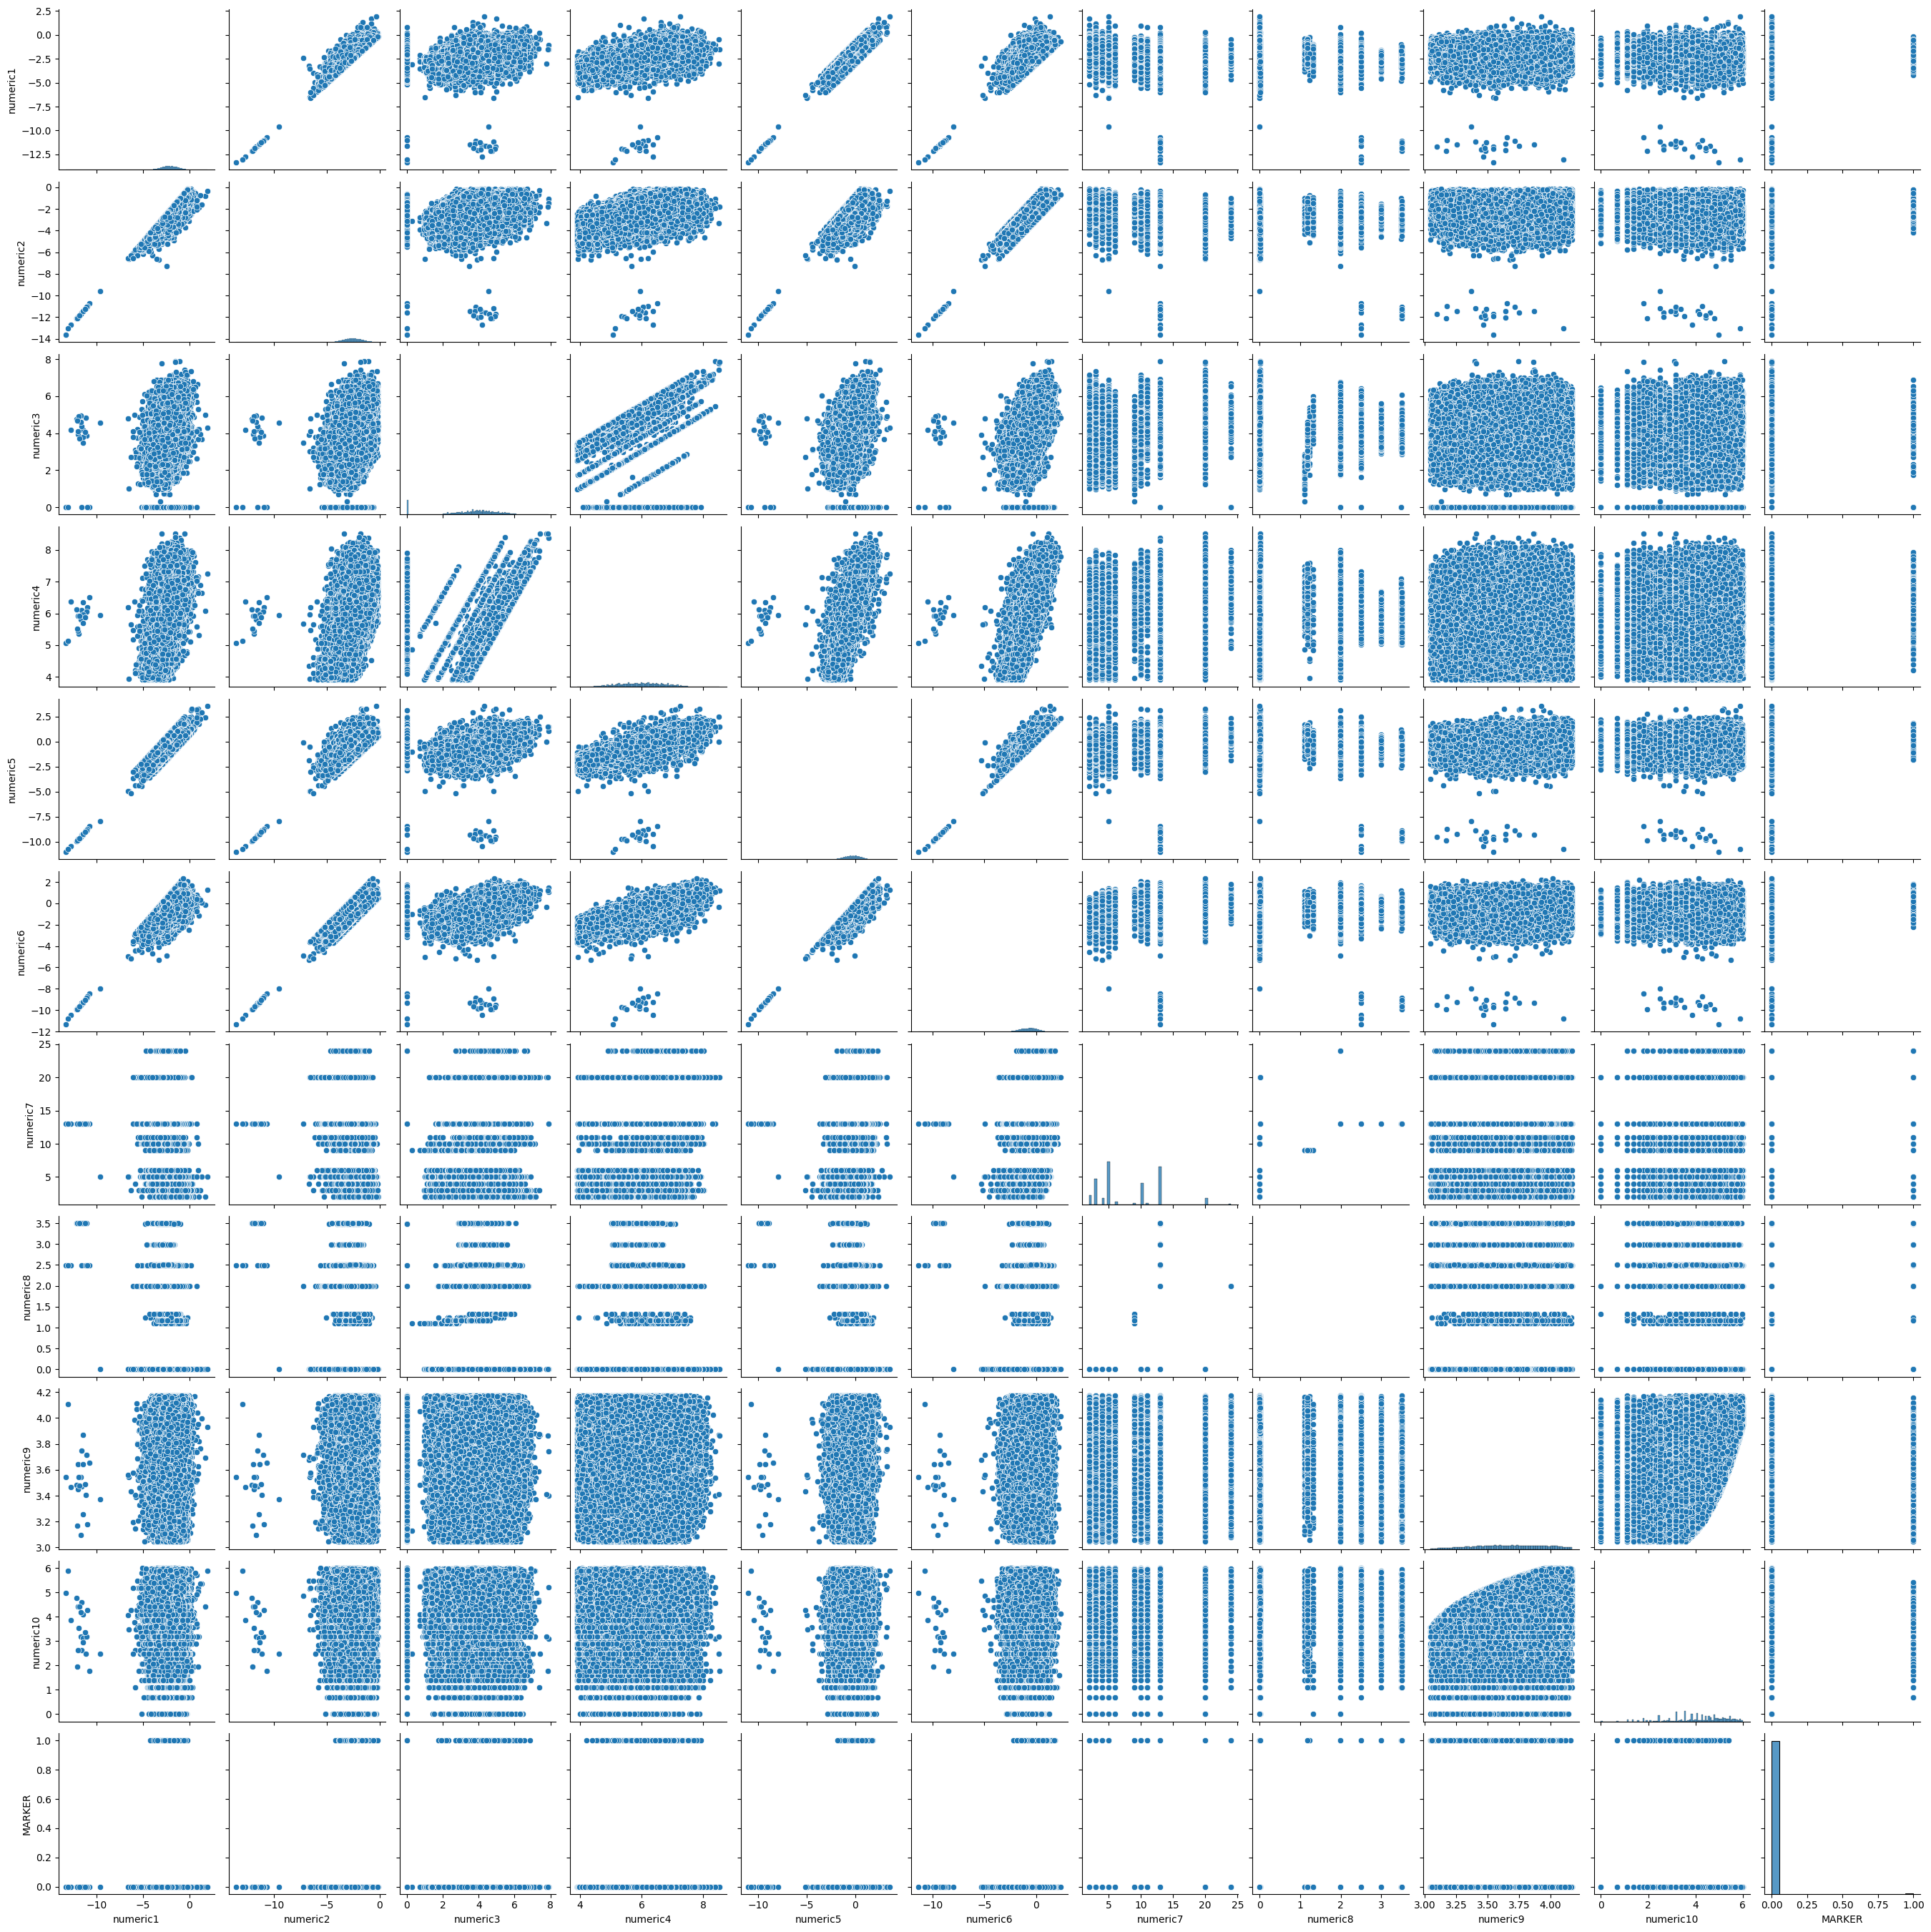

In [46]:
%%time
plt.figure(figsize=(12, 6))
sns.pairplot(numeric_df)

Видно, что у большинства признаков при их совместном двумерном построения есть определенные паттерны распределения:
* Сильная линейная корреляция между признаками numeric [1-5], [2-6], [3-4], причём линейность проявляется в нескольких направлениях
* Некоторые комбинации диаграмм рассеяния ограничены какой то константной линией, как например в случаях numeric [1-2], [5-6], [9-10]
* Дискретные признаки numeric [7-8] дают в совокупности небольшое количество кластеров

### Ridge & Lasso

In [47]:
from sklearn.linear_model import Lasso, Ridge
X, y = numeric_df.drop(['MARKER'], axis=1), numeric_df['MARKER']
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
print("LASSO Coefficients:", lasso.coef_)
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
print("Ridge Coefficients:", ridge.coef_)

LASSO Coefficients: [ 0.  0. -0.  0.  0.  0.  0.  0. -0. -0.]
Ridge Coefficients: [ 3.12158021e-04  3.20489066e-03  7.99235780e-05  2.08656121e-03
 -2.71411820e-03  1.78614437e-04  3.46891734e-04  4.47678255e-03
 -1.32714401e-03 -1.96293605e-03]


L1 занулила слишком много признаков, нужно попробовать другие методы

### Коэффициент инфляции дисперсии

Самый простой и эффективный метод решения проблем с мультколлинеарностью это удаление сильно коррелирующих переменных.

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
def vif_analisys(df):
    X = add_constant(df)
    
    VIFs = pd.DataFrame()
    VIFs['Variable'] = X.columns
    VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return VIFs.transpose()

In [ ]:
vif_analisys(numeric_df.drop(['MARKER'], axis=1))

In [ ]:
vif_analisys(numeric_df.drop(['MARKER', 'numeric2', 'numeric5'], axis=1))

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.drop(['MARKER', 'numeric2', 'numeric5'], axis=1).corr(), annot=True, cmap="YlGnBu")

Хоть значения VIF значительно уменьшились, но высокая корреляция между некоторыми оставшимися признаками сохранилась

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def reduce_multi_pca(numeric_df, n=numeric_df.shape[1]-1):
    X, y = numeric_df.drop(['MARKER'], axis=1), numeric_df['MARKER']
    pca = PCA(n_components=n)
    pca = pca.fit_transform(X)
    df_pca = pd.DataFrame(pca)
    print(df_pca.shape)
    return df_pca

In [ ]:
df_pca = reduce_multi_pca(numeric_df, n=10)
plt.figure(figsize=(12, 6))
sns.heatmap(df_pca.corr(), annot=True, cmap="YlGnBu")

Судя по тепловой карте мы избавились от мультиколлинеарности, но из-за смещения осей некоторая информация между признаками могла 'слиться', поэтому нельзя однозначно сказать как это скажется на результах модели.

## Boruta

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def boruta_selection(df):
    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_
    X, y = df.drop(['MARKER'], axis=1).values, numeric_df['MARKER'].values
    X, y = under_sampling(X, y, coef_imbalance=1)
    rf = RandomForestClassifier(n_estimators=100)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
    boruta.fit(X, y)
    selected_features = numeric_df.drop(['MARKER'], axis=1).columns[boruta.support_]
    return selected_features

In [ ]:
selected_features = boruta_selection(numeric_df)

In [ ]:
selected_features 

## Выгрузка предобработанных данных

In [ ]:
%%time
# add path to load 
dirpath = os.getcwd()
path_to_load = Path(dirpath) / 'transformed_data'
os.makedirs(path_to_load, exist_ok=True)

# write data
for filename, df in data.items():
    filepath = path_to_load / filename
    with open(filepath, mode='w', newline='') as file:
        df.to_csv(filepath, index=False)

In [ ]:
# check for correct saving
print(*[f+"\n" for f in os.listdir(path_to_load) if os.path.isfile(os.path.join(path_to_load, f))])

# Валидация, оптимизация, обучение

## Библиотеки

In [ ]:
# Логистическая
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, fbeta_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight

## Чтение предобработанных данных

In [ ]:
%%time
# get directory path
dirpath = os.getcwd()
clean_data_path = Path(dirpath) / 'transformed_data'

# load data to dict
data = {}
for file_path in clean_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path)
        print(file_path.stem, data[file_path.stem].shape)

## Разделение на таргет и признаки

In [ ]:
X, y = split_data(data['Training'])

## Получение интересующих нас метрик

In [ ]:
# to save metrics from models
metrics_data = {}

In [ ]:
def get_metrics(y_train_pred, y_val_pred, y_test, y_train, threshold=0.5):

    # классификация
    y_train_01 = y_train_pred >= threshold
    y_val_01 = y_val_pred >= threshold

    # подсчёт метрик
    metrics_df = pd.DataFrame(columns=['Metric', 'Score'])
    metrics_df['Metric'] = [
                            'fbeta',
                            'F1',
                            'Precision',
                            'Recall',
                            'ROC AUC',
                            'Gini'
                           ]
    metrics_df['Score'] = [
                            fbeta_score(y_test, y_val_01, beta=145),
                            f1_score(y_test, y_val_01),
                            precision_score(y_test, y_val_01),
                            recall_score(y_test, y_val_01),
                            roc_auc_score(y_test, y_val_01),
                            2*roc_auc_score(y_test, y_val_01)-1
                          ]

    # матрицы
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.heatmap(confusion_matrix(y_train, y_train_01), annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix for train data')
    
    sns.heatmap(confusion_matrix(y_test, y_val_01), annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax2)
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    ax2.set_title('Confusion Matrix for test data')
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()
        
    return metrics_df

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')      

In [ ]:
get_metrics(np.array([1, 0.5, 0, 0.5]), np.array([0, 0.5, 0.5, 1]), np.array([1, 0, 0, 1]), np.array([0, 0, 0, 0]), threshold=0.7)

## Логистическая регрессия

Логистическая регрессия один из самых распространнёных алгоритмов в задачах крединтного скоринга. Его основными преимуществами является лёгкость и быстрота обучения, а также простая интерпретируемость. 

Помимо предобработки признаков, моменты, которые следует учесть:
1. Нормализация данных
2. Балансировка классов (будет решаться за счёт установки весов для каждого класса в соответсвии количеству записей)
3. Мультиколлинеарность (будет решаться за счёт регуляризации)
4. Оптимизация гиперпараметров

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

### Оптимизация гиперпараметров

In [ ]:
def lr_cv(C, max_iter):
    #f1_scorer = make_scorer(f1_score, average='weighted')
    recall_scorer = make_scorer(recall_score)
    # precision_scorer = make_scorer(precision_score)
    scaler = StandardScaler()
    model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', C=C, max_iter=int(max_iter)))
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    val_score = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer).mean()
    return val_score.mean()

### Реализация модели

In [ ]:
def log_reg(X, y, scaler = StandardScaler(), seed=42, opt_iter=15):
    # оптимизация
    opt = BayesianOptimization(
        f=lr_cv,
        pbounds={'C': (0.01, 10), 
         'max_iter': (50, 1000)},
        verbose=1,
        random_state=42,
    )
    opt.maximize(n_iter=opt_iter)
    print(opt.max)

    # сплит
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    
    # нормализация
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.fit_transform(X_test)
    
    # обучение 
    model = LogisticRegression(class_weight='balanced', C=opt.max['params']['C'], max_iter=int(opt.max['params']['max_iter']))
    model.fit(X_scaled_train, y_train)
    
    # предикт
    y_train_pred = model.predict_proba(X_scaled_train)[:, 1]
    y_val_pred = model.predict_proba(X_scaled_test)[:, 1]

    return y_train_pred, y_val_pred, y_test

In [ ]:
%%time
y_train_pred, y_val_pred, y_test = log_reg(X, y, opt_iter=20)

In [ ]:
sns.histplot(y_train_pred)

In [ ]:
# save metrics
metrics_data['logistic_regression'] = get_metrics(y_train_pred, y_val_pred, y_test, y_train, threshold=0.5)

In [ ]:
metrics_data['logistic_regression']

## Бустинг

Бустинг считается одним из лучших алгоритмов для работы с табличными данными. Также бустинг за счёт постоянной коррекции ошибки и настраиваемых весов классов, позволит найти хорошее разделение по таргету для несбалансированных данных.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

In [ ]:
X.shape[0] / y.sum() 

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# def under_sampling(X, y, k=1):
#     rus = RandomUnderSampler(sampling_strategy={0: k*271, 1: 271}) #sampling_strategy='majority'
#     X, y = rus.fit_resample(X, y)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)#, random_state=42 )
#     print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#     return X, y
# X_und, y_und = under_sampling(X, y, k=1)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization

def cb_cv(iterations, learning_rate, depth, l2_leaf_reg):
    recall_scorer = make_scorer(recall_score)
    model = CatBoostClassifier(iterations=int(iterations),
                               learning_rate=learning_rate,
                               depth=int(depth),
                               l2_leaf_reg=l2_leaf_reg,
                               auto_class_weights='Balanced',
                               verbose=False)
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    val_score = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer).mean()
    return val_score.mean()

pbounds = {
           'iterations': (300, 1000),
           'learning_rate': (0.00001, 0.005),
           'depth': (3, 10),
           'l2_leaf_reg': (0, 10)
}
optimizer = BayesianOptimization(f=cb_cv, pbounds=pbounds, random_state=42, verbose=1)
optimizer.maximize(init_points=5, n_iter=50)
# print(optimizer.max)

In [ ]:
model = CatBoostClassifier(
                           auto_class_weights='Balanced',
                           iterations=int(optimizer.max['params']['iterations']),
                           depth=int(optimizer.max['params']['depth']),
                           l2_leaf_reg=optimizer.max['params']['l2_leaf_reg'],
                           learning_rate=optimizer.max['params']['learning_rate'],
                           verbose=False
                          )

model.fit(X_train, y_train, eval_set=(X_validation, y_validation), plot=True)

In [ ]:
y_train_pred = model.predict_proba(X_train)[:, 1]
y_val_pred = model.predict_proba(X_validation)[:, 1]

In [ ]:
sns.histplot(y_train_pred)

In [ ]:
metrics_data['catboost'] = get_metrics(y_train_pred, y_val_pred, y_test, y_train, threshold=0.5)

In [ ]:
metrics_data['catboost']

In [ ]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_validation)

# Оценка качества модели
print(classification_report(y_validation, y_val_pred))

## Нейронная сеть

Так как данные зашифрованны, то возможности в проведении EDA частично ограничены, в связи с чем неплохим решением будет обучение нейросети, которая потенциально может выявить какие-то неочевидные паттерны в данных.

### Подготовка

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)

In [ ]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [ ]:
weight_for_0 = (1 / y_train.where(y_train == 0).count()) * (y_train.count() / 2.0)
weight_for_1 = (1 / y_train.sum()) * (y_train.count() / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # model's loss
      # keras.metrics.MeanSquaredError(name='Brier score'),
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.F1Score(name='F1'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          24, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dense(
          12, activation='relu',
          input_shape=(12, )),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Предобучение для подбора весов инициализации

In [ ]:
EPOCHS = 300
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

In [ ]:
model.predict(X_train[:10])

In [ ]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

In [ ]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights.weights.h5')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_validation, y_validation), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_validation, y_validation), 
    verbose=0)

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Обучение моделей

### Взвешенная модель

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train.reset_index(drop=True),
    batch_size=BATCH_SIZE,
    epochs=60,
    callbacks=[early_stopping],
    validation_data=(X_validation, y_validation),
    class_weight=class_weight,
    verbose=0
)

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
validation_predictions_weighted = weighted_model.predict(X_validation, batch_size=BATCH_SIZE)

In [ ]:
metrics_data['neural_network_weighted'] = get_metrics(train_predictions_weighted, validation_predictions_weighted, y_validation, y_train)

### Модель на дублирующемся минорном классе

#### Подготовка

In [ ]:
train_df, val_df = train_test_split(data['Training'], test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('MARKER'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('MARKER'))

train_features = np.array(train_df)
val_features = np.array(val_df)

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

print(f'res_pos_features shape: {res_pos_features.shape}')

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

print(f'resampled_features shape: {resampled_features.shape}')

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

In [ ]:
BATCH_SIZE = 2048

pos_ds = pos_ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))
neg_ds = neg_ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))

resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels.reshape(-1, 1))).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=15,
    callbacks=[early_stopping],
    validation_data=(val_ds),
    verbose=1
)

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
validation_predictions_resampled = resampled_model.predict(val_features, batch_size=BATCH_SIZE)

In [ ]:
metrics_data['neural_network_oversampling_by_copy1class'] = get_metrics(train_predictions_resampled, validation_predictions_resampled, val_labels, train_labels, threshold=0.5)

In [ ]:
metrics_data['neural_network_oversampling_by_copy1class']

In [ ]:
sns.histplot(validation_predictions_resampled, bins=100, kde=False)

## Сравнение моделей

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)

y_train_pred_dummy = dummy_clf.predict(X_train)
y_validation_pred_dummy = dummy_clf.predict(X_validation)

metrics_data['dummy_classifier'] = get_metrics(y_train_pred_dummy, y_validation_pred_dummy, y_validation, y_train)

In [ ]:
df = pd.concat(metrics_data.values(), keys=metrics_data.keys()).reset_index().pivot(index='level_1', columns='level_0', values='Score')

metrics = [metric for metric, _ in metrics_data['logistic_regression'].to_numpy()]
df.columns = [data_name.capitalize() for data_name in df.columns]
df.index = metrics

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

styled_df = df.style.apply(highlight_max, subset=df.columns, axis=1)
styled_df

* Если у dummy_classifiera метрика лучше или незначительно отличается по сравнению с остальными моделями - значит это метрика не подохдит для нашей задачи.
* Как видими по метрикам лучше всего с классификацией справляется нейросеть 

## Применение лучшей модели на тестовую выборку

In [ ]:
X_test, y_test = data['Test'].drop(['MARKER'], axis=1), data['Test']['MARKER']

In [ ]:
scaler = StandardScaler()
model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', C=3.75, max_iter=953))

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_train_pred = model.predict_proba(X_scaled_train)[:, 1]
y_test_pred = model.predict_proba(X_scaled_test)[:, 1]

### Как можно было улучшить результат

* Чистка выбросов по таргету, а не по всей выборке
* Попробовать сделать oversampling, который мог потенциально очень хорошо
* Попробовать бустинг, реализованный для работы с несбалансированными классами MEBoost
* Добавить оптимизацию гиперпараметров для сети, а потом обучить с начальными весами, полученными с предобученной нейросети
* Для обучения моделей делать более генерализированные выборки путём кластеризации ( в случаях когда мы обучаемся на малых частях данных, например в случае бустинга или семплирования батчей для нейросети вручную), потому что стратифицированный отбор не гарантирует генералилизируемость выборки
* Сделать жадный перебор всем возможных комбинаций из вариантов решения проблемы дизбаланса классов, мультиколлинеарности и модели, в результате чего выбрать лучшую